[parse_sniper] Searching under: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z
[parse_sniper] Merged DataFrame shape: (24, 19)
[parse_dynamorio] Searching logs: /home/skataoka26/COSC_498/miniMXE/results_trace/logs (prefix=20250929T203551Z)
[parse_dynamorio] Processed 12 files; rows=12

Saved correlation artifacts to: /home/skataoka26
Features used: ['rtotal', 'runique', '90%f_tr', 'Hrg', 'Hrl', 'wtotal', 'wunique', '90%f_tw', 'Hwg', 'Hwl', 'rw_ratio_total', 'rw_ratio_unique', 'rw_ratio_global_entropy', 'rw_ratio_local_entropy', 'rw_ratio_90_footprint']
JanS targets: ['Dyn_energy', 'Leakage', 'LLC_energy', 'exe_time']


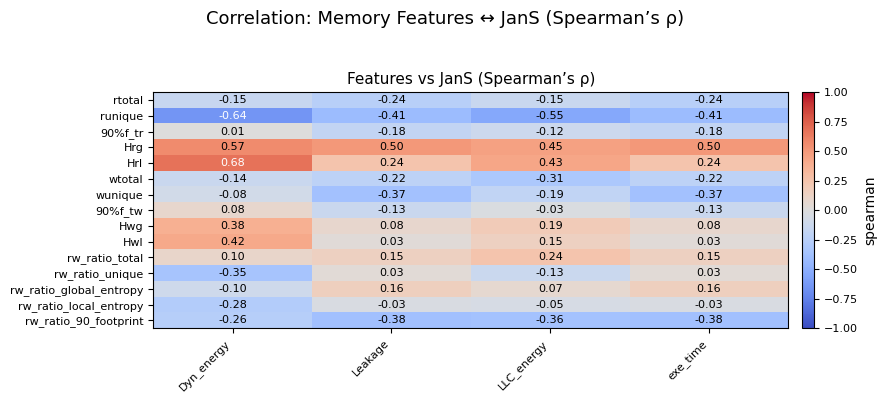

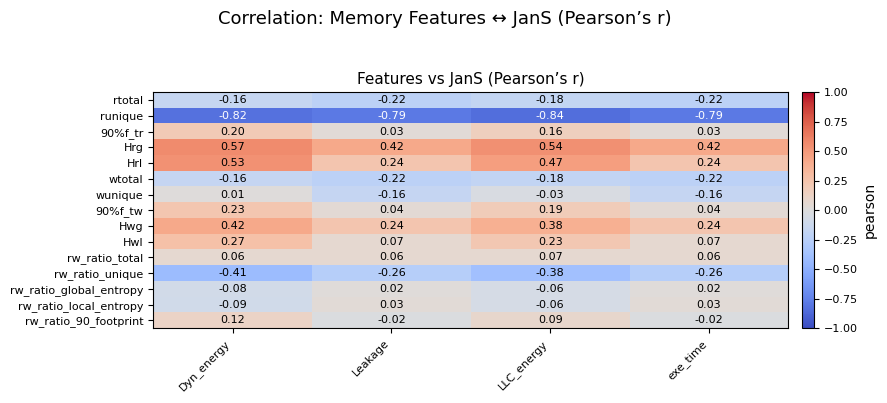

In [10]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SNIPER_RESULTS_DIR = "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z"
# sniper_llc_2mb_16w_20251002T020032Z
# sniper_llc_32mb_16w_20251002T020050Z
DYNAMORIO_LOGS_DIR = "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
TIMESTAMP_PREFIX = "20250929T203551Z"  # prefix used in DynamoRIO filenames

# -----------------------------
# Utilities
# -----------------------------
def safe_div(numer, denom):
    numer = np.array(numer, dtype=float)
    denom = np.array(denom, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = np.where((denom > 0) & np.isfinite(denom), numer / denom, np.nan)
    return out

def geomean(values):
    vals = np.array([v for v in np.ravel(values) if v > 0 and np.isfinite(v)], dtype=float)
    return float(np.exp(np.mean(np.log(vals)))) if len(vals) else np.nan

# -----------------------------
# Parsing helpers (Sniper & DynamoRIO)
# -----------------------------
def parse_sniper(base_dir):
    """
    Walk output_* folders, read summary.csv and energy_bounds.csv,
    merge them on (benchmark, config). Return a tidy DataFrame.
    """
    energy_rows = []
    summary_rows = []
    print(f"[parse_sniper] Searching under: {base_dir}")
    for root, _, files in os.walk(base_dir):
        if os.path.basename(root).startswith("output_") and "summary.csv" in files and "energy_bounds.csv" in files:
            energy_path = os.path.join(root, "energy_bounds.csv")
            summary_path = os.path.join(root, "summary.csv")
            try:
                e = pd.read_csv(energy_path)
                s = pd.read_csv(summary_path)
            except Exception:
                continue

            # Keep relevant cols if present
            e_keep = ["benchmark", "config", "time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]
            e = e[[c for c in e_keep if c in e.columns]].copy()
            s_base = ["benchmark", "config", "ipc", "time_ns", "l3_miss_rate_pct"]
            keep_s = [c for c in s_base if c in s.columns]

            # Also keep any LLC/l3 counters (best-effort)
            for col in s.columns:
                cl = col.lower()
                if ("l3" in cl or "llc" in cl) and (
                    "access" in cl or "read" in cl or "write" in cl or "hit" in cl or "miss" in cl or "evict" in cl or "wb" in cl
                ):
                    if col not in keep_s:
                        keep_s.append(col)
            s = s[keep_s].copy()

            # Numeric coercion
            for col in ["time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]:
                if col in e.columns:
                    e[col] = pd.to_numeric(e[col], errors="coerce")
            for col in s.columns:
                if col not in ("benchmark", "config"):
                    s[col] = pd.to_numeric(s[col], errors="coerce")

            if "dyn_exact_nJ" in e.columns:
                e["dyn_exact_J"] = e["dyn_exact_nJ"] * 1e-9

            energy_rows.append(e)
            summary_rows.append(s)

    if not energy_rows or not summary_rows:
        raise FileNotFoundError(f"Could not find summary.csv and energy_bounds.csv under: {base_dir}")

    E = pd.concat(energy_rows, ignore_index=True)
    S = pd.concat(summary_rows, ignore_index=True)
    df = pd.merge(E, S, on=["benchmark", "config"], how="inner")
    df = df.dropna(subset=["benchmark", "config", "time_s", "energy_exact_J"])
    print(f"[parse_sniper] Merged DataFrame shape: {df.shape}")
    return df

def _kv_from_line(s: str) -> dict:
    kv = {}
    m = re.search(r"\bscope=(\w+)", s)
    if m:
        kv["scope"] = m.group(1)
    for k, v in re.findall(r"([A-Za-z0-9_]+)=([+\-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+\-]?\d+)?|nan)", s):
        try:
            kv[k] = float("nan") if v.lower() == "nan" else float(v)
        except Exception:
            pass
    return kv

def parse_dynamorio(logs_dir, ts_prefix):
    """
    Parse DynamoRIO log files by aggregating *per-interval* rows correctly.

    - Considers only lines with scope=interval or scope=final.
    - Sums per-interval totals (read_total/write_total).
    - Weighted-averages entropies & 90% footprints by the corresponding op totals.
    - Uses the last snapshot for cumulative fields (reads, writes, bytes_*, global_footprint_bytes, *_unique_lines).
    - Sets read_unique/write_unique to final *_unique_lines if available, else max( per-interval read_unique/write_unique ).
    - For instrs/instructions: choose max(sum over intervals, last snapshot).

    File name format: {ts_prefix}_<benchmark>_instr.rwstats.log
    """
    rows = []
    print(f"[parse_dynamorio] Searching logs: {logs_dir} (prefix={ts_prefix})")
    if not os.path.isdir(logs_dir):
        print("[parse_dynamorio] Logs dir not found; returning empty DataFrame.")
        return pd.DataFrame()

    # Keys we will aggregate/use
    r_weight_keys = {"read_entropy", "read_local_entropy", "read_footprint90L"}
    w_weight_keys = {"write_entropy", "write_local_entropy", "write_footprint90L"}
    cumulative_last_keys = [
        "reads", "writes", "bytes_read", "bytes_written",
        "global_footprint_bytes", "read_unique_lines", "write_unique_lines",
    ]
    max_keys = ["read_unique", "write_unique", "uniq_lines", "uniq_pages", "footprint_bytes"]

    found = 0
    for fname in os.listdir(logs_dir):
        if not (fname.startswith(ts_prefix) and fname.endswith("_instr.rwstats.log")):
            continue
        m = re.match(rf"{re.escape(ts_prefix)}_(.+?)_instr\.rwstats\.log$", fname)
        if not m:
            continue
        found += 1
        benchmark = m.group(1)
        fpath = os.path.join(logs_dir, fname)

        # Collect relevant interval-like rows only
        ivals = []
        try:
            with open(fpath, "r", errors="ignore") as f:
                for line in f:
                    if "scope=" not in line:
                        continue
                    kv = _kv_from_line(line.strip())
                    if not kv:
                        continue
                    sc = str(kv.get("scope", "")).lower()
                    if sc in ("interval", "final"):  # treat 'final' like one more interval
                        ivals.append(kv)
        except Exception:
            continue

        if not ivals:
            continue

        # Prepare weights: prefer explicit per-interval totals; else fall back to deltas of cumulative counters
        reads_seq = [r.get("reads", np.nan) for r in ivals]
        writes_seq = [r.get("writes", np.nan) for r in ivals]
        # deltas (first interval delta unknown -> NaN)
        dreads = [np.nan]
        dwrites = [np.nan]
        for i in range(1, len(ivals)):
            a, b = reads_seq[i-1], reads_seq[i]
            c, d = writes_seq[i-1], writes_seq[i]
            dreads.append((b - a) if (np.isfinite(a) and np.isfinite(b) and b >= a) else np.nan)
            dwrites.append((d - c) if (np.isfinite(c) and np.isfinite(d) and d >= c) else np.nan)

        r_wts = []
        w_wts = []
        for i, r in enumerate(ivals):
            rtot = r.get("read_total", np.nan)
            wtot = r.get("write_total", np.nan)
            r_wts.append(rtot if np.isfinite(rtot) else dreads[i])
            w_wts.append(wtot if np.isfinite(wtot) else dwrites[i])

        # Aggregate totals
        sum_read_total = float(np.nansum([w for w in r_wts if np.isfinite(w)])) if any(np.isfinite(w) for w in r_wts) else np.nan
        sum_write_total = float(np.nansum([w for w in w_wts if np.isfinite(w)])) if any(np.isfinite(w) for w in w_wts) else np.nan

        # Weighted averages
        agg = {"benchmark": benchmark, "scope": "aggregate"}
        agg["read_total"] = sum_read_total
        agg["write_total"] = sum_write_total

        def _wavg(keys, weights, which):
            den = float(np.nansum([w for w in weights if np.isfinite(w)]))
            for k in keys:
                num = 0.0
                if den > 0:
                    for i, row in enumerate(ivals):
                        v = row.get(k, np.nan)
                        w = weights[i]
                        if np.isfinite(v) and np.isfinite(w) and w > 0:
                            num += v * w
                    agg[k] = num / den if den > 0 else np.nan
                else:
                    agg[k] = np.nan

        _wavg(r_weight_keys, r_wts, "read")
        _wavg(w_weight_keys, w_wts, "write")

        # Last-snapshot cumulative fields
        for k in cumulative_last_keys:
            for row in reversed(ivals):
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    agg[k] = v
                    break

        # Unique counts: prefer *_unique_lines (cumulative), else max per-interval unique
        if np.isfinite(agg.get("read_unique_lines", np.nan)):
            agg["read_unique"] = agg["read_unique_lines"]
        else:
            rmax = np.nan
            for row in ivals:
                v = row.get("read_unique", np.nan)
                if np.isfinite(v):
                    rmax = v if not np.isfinite(rmax) else max(rmax, v)
            if np.isfinite(rmax):
                agg["read_unique"] = rmax

        if np.isfinite(agg.get("write_unique_lines", np.nan)):
            agg["write_unique"] = agg["write_unique_lines"]
        else:
            wmax = np.nan
            for row in ivals:
                v = row.get("write_unique", np.nan)
                if np.isfinite(v):
                    wmax = v if not np.isfinite(wmax) else max(wmax, v)
            if np.isfinite(wmax):
                agg["write_unique"] = wmax

        # Max-type fields for reference (not critical to current feature map)
        for k in max_keys:
            vmax = np.nan
            for row in ivals:
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    vmax = v if not np.isfinite(vmax) else max(vmax, v)
            if np.isfinite(vmax):
                agg[k] = vmax

        # Instructions: choose max(sum of per-interval, last snapshot)
        for k in ("instrs", "instructions"):
            s = float(np.nansum([row.get(k, np.nan) for row in ivals if np.isfinite(row.get(k, np.nan))]))
            lastv = np.nan
            for row in reversed(ivals):
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    lastv = v
                    break
            if np.isfinite(s) or np.isfinite(lastv):
                agg[k] = max(s if np.isfinite(s) else -np.inf, lastv if np.isfinite(lastv) else -np.inf)

        rows.append(agg)

    print(f"[parse_dynamorio] Processed {found} files; rows={len(rows)}")
    return pd.DataFrame(rows)

# -----------------------------
# Plot helper (compact heatmap)
# -----------------------------
def corr_heatmap(ax, matrix, row_labels, col_labels, title):
    im = ax.imshow(matrix, aspect="auto", vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha="right")
    ax.set_title(title, fontsize=11)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                        color="white" if abs(val) > 0.6 else "black", fontsize=8)
    return im

# -----------------------------
# Main (compact correlation-only)
# -----------------------------
def main():
    out_dir = os.getcwd()

    # Load data
    sniper = parse_sniper(SNIPER_RESULTS_DIR)
    dr = parse_dynamorio(DYNAMORIO_LOGS_DIR, TIMESTAMP_PREFIX)

    # Save raw (light)
    sniper.to_csv(os.path.join(out_dir, "sniper_raw.csv"), index=False)
    if not dr.empty:
        dr.to_csv(os.path.join(out_dir, "dynamorio_raw.csv"), index=False)

    # Focus on SRAM & JanS
    sram = sniper[sniper["config"] == "SRAM"].set_index("benchmark")
    jans = sniper[sniper["config"] == "JanS"].set_index("benchmark")
    common = sram.index.intersection(jans.index)
    if len(common) < 2:
        raise RuntimeError("Need at least 2 common benchmarks between SRAM and JanS for correlations.")

    # stable ordering (sort by SRAM time)
    order = sram.loc[common].sort_values("time_s").index.tolist()
    sram = sram.loc[order]
    jans = jans.loc[order]
    labels = order

    # DynamoRIO features mapping (concise)
    feat_map = {
        "rtotal": "read_total",
        "runique": "read_unique",
        "90%f_tr": "read_footprint90L",
        "Hrg": "read_entropy",
        "Hrl": "read_local_entropy",
        "wtotal": "write_total",
        "wunique": "write_unique",
        "90%f_tw": "write_footprint90L",
        "Hwg": "write_entropy",
        "Hwl": "write_local_entropy",
    }

    if dr.empty:
        raise RuntimeError("DynamoRIO data not found — cannot compute correlations.")

    feats = pd.DataFrame({"benchmark": dr["benchmark"]})
    for out_name, src in feat_map.items():
        feats[out_name] = pd.to_numeric(dr.get(src), errors="coerce")
    feats = feats.set_index("benchmark")

    # Add intensity features if instruction column exists
    dr_idx = dr.set_index("benchmark")
    instr_col = 'instrs' if 'instrs' in dr_idx.columns else ('instructions' if 'instructions' in dr_idx.columns else None)
    if instr_col:
        instr_count = pd.to_numeric(dr_idx[instr_col], errors='coerce')
        feats['read_intensity'] = safe_div(feats.get('rtotal'), instr_count)
        feats['write_intensity'] = safe_div(feats.get('wtotal'), instr_count)

    # ratio features
    feats['rw_ratio_total'] = safe_div(feats.get('rtotal'), feats.get('wtotal'))
    feats['rw_ratio_unique'] = safe_div(feats.get('runique'), feats.get('wunique'))
    feats['rw_ratio_global_entropy'] = safe_div(feats.get('Hrg'), feats.get('Hwg'))
    feats['rw_ratio_local_entropy'] = safe_div(feats.get('Hrl'), feats.get('Hwl'))
    feats['rw_ratio_90_footprint'] = safe_div(feats.get('90%f_tr'), feats.get('90%f_tw'))

    # JanS targets: exactly as requested (dyn, leak, total, time)
    targets_jans = jans[["dyn_exact_J", "leak_J", "energy_exact_J", "time_s"]].copy()
    targets_jans = targets_jans.rename(columns={
        "dyn_exact_J": "Dyn_energy",
        "leak_J": "Leakage",
        "energy_exact_J": "LLC_energy",
        "time_s": "exe_time",
    })

    # Join features with targets
    corr_df = feats.join(targets_jans, how="inner")
    corr_df = corr_df.loc[corr_df.index.intersection(labels)]
    corr_df = corr_df.reindex(labels)

    if corr_df.shape[0] < 2:
        raise RuntimeError("Not enough overlapping benchmarks after join to compute correlations.")

    # Candidate features (keep only those present with some data)
    candidate_features = [
        "rtotal","runique","90%f_tr","Hrg","Hrl",
        "wtotal","wunique","90%f_tw","Hwg","Hwl",
        "read_intensity","write_intensity",
        "rw_ratio_total","rw_ratio_unique",
        "rw_ratio_global_entropy","rw_ratio_local_entropy","rw_ratio_90_footprint"
    ]
    feature_names = [f for f in candidate_features if f in corr_df.columns and not corr_df[f].isna().all()]

    jan_cols = ["Dyn_energy", "Leakage", "LLC_energy", "exe_time"]
    jan_cols = [c for c in jan_cols if c in corr_df.columns and not corr_df[c].isna().all()]

    if not feature_names or not jan_cols:
        raise RuntimeError("Missing features or JanS target columns for correlation.")

    # Save the joined input for transparency
    corr_df.to_csv(os.path.join(out_dir, "corr_input_joined.csv"))

    # Compute correlations and plot heatmaps for Spearman & Pearson
    methods = [("spearman", "Spearman\u2019s \u03c1"), ("pearson", "Pearson\u2019s r")]
    saved_mats = {}
    plt.rcParams.update({
        "figure.figsize": (10, max(4, 0.25 * len(feature_names))),
        "axes.titlesize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    })

    for method, pretty in methods:
        M = corr_df[feature_names + jan_cols].corr(method=method).loc[feature_names, jan_cols].values
        dfmat = pd.DataFrame(M, index=feature_names, columns=jan_cols)
        saved_mats[method] = dfmat
        # figure
        fig, ax = plt.subplots(1, 1, figsize=(9, max(4, 0.25 * len(feature_names))))
        im = corr_heatmap(ax, M, feature_names, jan_cols, f"Features vs JanS ({pretty})")
        cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
        cbar.set_label(method)
        fig.suptitle(f"Correlation: Memory Features \u2194 JanS ({pretty})", y=0.995, fontsize=13)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        fig.savefig(os.path.join(out_dir, f"corr_heatmap_{method}.png"), dpi=200, bbox_inches="tight")

    # Save matrices
    for m, dfmat in saved_mats.items():
        dfmat.to_csv(os.path.join(out_dir, f"corr_matrix_{m}.csv"))

    print("\nSaved correlation artifacts to:", out_dir)
    print("Features used:", feature_names)
    print("JanS targets:", jan_cols)

    plt.show()

if __name__ == "__main__":
    main()

[parse_sniper] Searching under: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z
[parse_sniper] Merged DataFrame shape: (24, 19)
[parse_dynamorio] Searching logs: /home/skataoka26/COSC_498/miniMXE/results_trace/logs (prefix=20250929T203551Z)
[parse_dynamorio] Processed 12 files; rows=12

Saved correlation artifacts to: /home/skataoka26
Features used: ['rtotal', 'runique', '90%f_tr', 'Hrg', 'Hrl', 'wtotal', 'wunique', '90%f_tw', 'Hwg', 'Hwl', 'rw_ratio_total', 'rw_ratio_unique', 'rw_ratio_global_entropy', 'rw_ratio_local_entropy', 'rw_ratio_90_footprint']
JanS targets: ['dyn_energy_ratio', 'energy_ratio', 'exe_time_ratio']


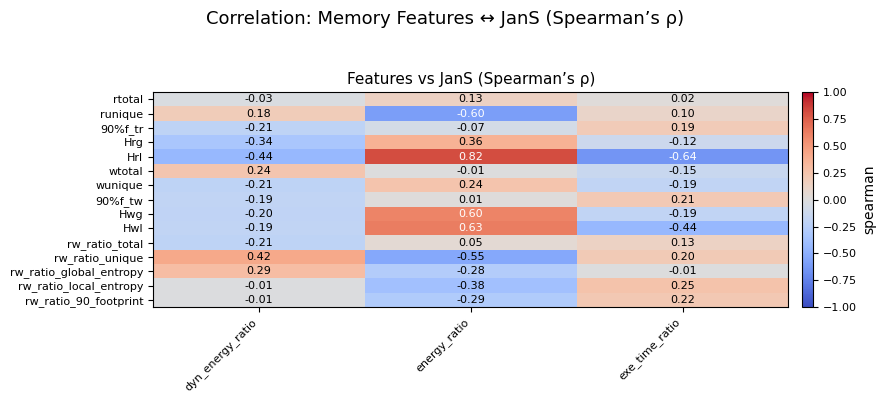

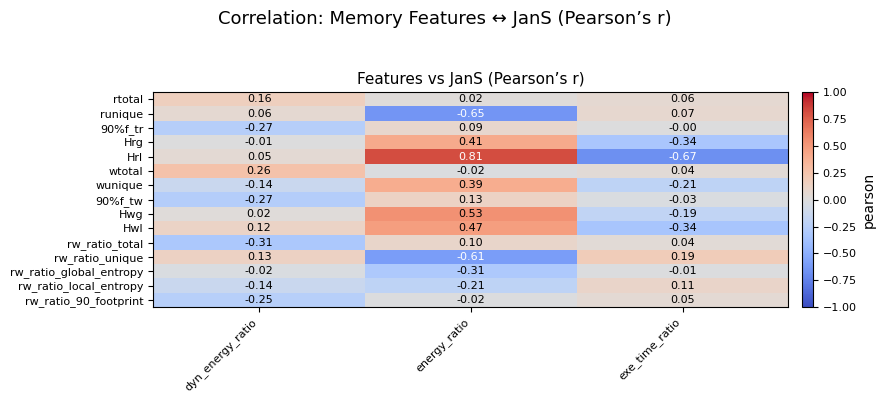

In [11]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SNIPER_RESULTS_DIR = "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z"
# sniper_llc_2mb_16w_20251002T020032Z
# sniper_llc_32mb_16w_20251002T020050Z
DYNAMORIO_LOGS_DIR = "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
TIMESTAMP_PREFIX = "20250929T203551Z"  # prefix used in DynamoRIO filenames
# -----------------------------
# Utilities
# -----------------------------
def safe_div(numer, denom):
    numer = np.array(numer, dtype=float)
    denom = np.array(denom, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = np.where((denom > 0) & np.isfinite(denom), numer / denom, np.nan)
    return out

def geomean(values):
    vals = np.array([v for v in np.ravel(values) if v > 0 and np.isfinite(v)], dtype=float)
    return float(np.exp(np.mean(np.log(vals)))) if len(vals) else np.nan

# -----------------------------
# Parsing helpers (Sniper & DynamoRIO)
# -----------------------------
def parse_sniper(base_dir):
    """
    Walk output_* folders, read summary.csv and energy_bounds.csv,
    merge them on (benchmark, config). Return a tidy DataFrame.
    """
    energy_rows = []
    summary_rows = []
    print(f"[parse_sniper] Searching under: {base_dir}")
    for root, _, files in os.walk(base_dir):
        if os.path.basename(root).startswith("output_") and "summary.csv" in files and "energy_bounds.csv" in files:
            energy_path = os.path.join(root, "energy_bounds.csv")
            summary_path = os.path.join(root, "summary.csv")
            try:
                e = pd.read_csv(energy_path)
                s = pd.read_csv(summary_path)
            except Exception:
                continue

            # Keep relevant cols if present
            e_keep = ["benchmark", "config", "time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]
            e = e[[c for c in e_keep if c in e.columns]].copy()
            s_base = ["benchmark", "config", "ipc", "time_ns", "l3_miss_rate_pct"]
            keep_s = [c for c in s_base if c in s.columns]

            # Also keep any LLC/l3 counters (best-effort)
            for col in s.columns:
                cl = col.lower()
                if ("l3" in cl or "llc" in cl) and (
                    "access" in cl or "read" in cl or "write" in cl or "hit" in cl or "miss" in cl or "evict" in cl or "wb" in cl
                ):
                    if col not in keep_s:
                        keep_s.append(col)
            s = s[keep_s].copy()

            # Numeric coercion
            for col in ["time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]:
                if col in e.columns:
                    e[col] = pd.to_numeric(e[col], errors="coerce")
            for col in s.columns:
                if col not in ("benchmark", "config"):
                    s[col] = pd.to_numeric(s[col], errors="coerce")

            if "dyn_exact_nJ" in e.columns:
                e["dyn_exact_J"] = e["dyn_exact_nJ"] * 1e-9

            energy_rows.append(e)
            summary_rows.append(s)

    if not energy_rows or not summary_rows:
        raise FileNotFoundError(f"Could not find summary.csv and energy_bounds.csv under: {base_dir}")

    E = pd.concat(energy_rows, ignore_index=True)
    S = pd.concat(summary_rows, ignore_index=True)
    df = pd.merge(E, S, on=["benchmark", "config"], how="inner")
    df = df.dropna(subset=["benchmark", "config", "time_s", "energy_exact_J"])
    print(f"[parse_sniper] Merged DataFrame shape: {df.shape}")
    return df

def _kv_from_line(s: str) -> dict:
    kv = {}
    m = re.search(r"\bscope=(\w+)", s)
    if m:
        kv["scope"] = m.group(1)
    for k, v in re.findall(r"([A-Za-z0-9_]+)=([+\-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+\-]?\d+)?|nan)", s):
        try:
            kv[k] = float("nan") if v.lower() == "nan" else float(v)
        except Exception:
            pass
    return kv

def parse_dynamorio(logs_dir, ts_prefix):
    """
    Parse DynamoRIO log files by aggregating *per-interval* rows correctly.

    - Considers only lines with scope=interval or scope=final.
    - Sums per-interval totals (read_total/write_total).
    - Weighted-averages entropies & 90% footprints by the corresponding op totals.
    - Uses the last snapshot for cumulative fields (reads, writes, bytes_*, global_footprint_bytes, *_unique_lines).
    - Sets read_unique/write_unique to final *_unique_lines if available, else max( per-interval read_unique/write_unique ).
    - For instrs/instructions: choose max(sum over intervals, last snapshot).

    File name format: {ts_prefix}_<benchmark>_instr.rwstats.log
    """
    rows = []
    print(f"[parse_dynamorio] Searching logs: {logs_dir} (prefix={ts_prefix})")
    if not os.path.isdir(logs_dir):
        print("[parse_dynamorio] Logs dir not found; returning empty DataFrame.")
        return pd.DataFrame()

    # Keys we will aggregate/use
    r_weight_keys = {"read_entropy", "read_local_entropy", "read_footprint90L"}
    w_weight_keys = {"write_entropy", "write_local_entropy", "write_footprint90L"}
    cumulative_last_keys = [
        "reads", "writes", "bytes_read", "bytes_written",
        "global_footprint_bytes", "read_unique_lines", "write_unique_lines",
    ]
    max_keys = ["read_unique", "write_unique", "uniq_lines", "uniq_pages", "footprint_bytes"]

    found = 0
    for fname in os.listdir(logs_dir):
        if not (fname.startswith(ts_prefix) and fname.endswith("_instr.rwstats.log")):
            continue
        m = re.match(rf"{re.escape(ts_prefix)}_(.+?)_instr\.rwstats\.log$", fname)
        if not m:
            continue
        found += 1
        benchmark = m.group(1)
        fpath = os.path.join(logs_dir, fname)

        # Collect relevant interval-like rows only
        ivals = []
        try:
            with open(fpath, "r", errors="ignore") as f:
                for line in f:
                    if "scope=" not in line:
                        continue
                    kv = _kv_from_line(line.strip())
                    if not kv:
                        continue
                    sc = str(kv.get("scope", "")).lower()
                    if sc in ("interval", "final"):  # treat 'final' like one more interval
                        ivals.append(kv)
        except Exception:
            continue

        if not ivals:
            continue

        # Prepare weights: prefer explicit per-interval totals; else fall back to deltas of cumulative counters
        reads_seq = [r.get("reads", np.nan) for r in ivals]
        writes_seq = [r.get("writes", np.nan) for r in ivals]
        # deltas (first interval delta unknown -> NaN)
        dreads = [np.nan]
        dwrites = [np.nan]
        for i in range(1, len(ivals)):
            a, b = reads_seq[i-1], reads_seq[i]
            c, d = writes_seq[i-1], writes_seq[i]
            dreads.append((b - a) if (np.isfinite(a) and np.isfinite(b) and b >= a) else np.nan)
            dwrites.append((d - c) if (np.isfinite(c) and np.isfinite(d) and d >= c) else np.nan)

        r_wts = []
        w_wts = []
        for i, r in enumerate(ivals):
            rtot = r.get("read_total", np.nan)
            wtot = r.get("write_total", np.nan)
            r_wts.append(rtot if np.isfinite(rtot) else dreads[i])
            w_wts.append(wtot if np.isfinite(wtot) else dwrites[i])

        # Aggregate totals
        sum_read_total = float(np.nansum([w for w in r_wts if np.isfinite(w)])) if any(np.isfinite(w) for w in r_wts) else np.nan
        sum_write_total = float(np.nansum([w for w in w_wts if np.isfinite(w)])) if any(np.isfinite(w) for w in w_wts) else np.nan

        # Weighted averages
        agg = {"benchmark": benchmark, "scope": "aggregate"}
        agg["read_total"] = sum_read_total
        agg["write_total"] = sum_write_total

        def _wavg(keys, weights, which):
            den = float(np.nansum([w for w in weights if np.isfinite(w)]))
            for k in keys:
                num = 0.0
                if den > 0:
                    for i, row in enumerate(ivals):
                        v = row.get(k, np.nan)
                        w = weights[i]
                        if np.isfinite(v) and np.isfinite(w) and w > 0:
                            num += v * w
                    agg[k] = num / den if den > 0 else np.nan
                else:
                    agg[k] = np.nan

        _wavg(r_weight_keys, r_wts, "read")
        _wavg(w_weight_keys, w_wts, "write")

        # Last-snapshot cumulative fields
        for k in cumulative_last_keys:
            for row in reversed(ivals):
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    agg[k] = v
                    break

        # Unique counts: prefer *_unique_lines (cumulative), else max per-interval unique
        if np.isfinite(agg.get("read_unique_lines", np.nan)):
            agg["read_unique"] = agg["read_unique_lines"]
        else:
            rmax = np.nan
            for row in ivals:
                v = row.get("read_unique", np.nan)
                if np.isfinite(v):
                    rmax = v if not np.isfinite(rmax) else max(rmax, v)
            if np.isfinite(rmax):
                agg["read_unique"] = rmax

        if np.isfinite(agg.get("write_unique_lines", np.nan)):
            agg["write_unique"] = agg["write_unique_lines"]
        else:
            wmax = np.nan
            for row in ivals:
                v = row.get("write_unique", np.nan)
                if np.isfinite(v):
                    wmax = v if not np.isfinite(wmax) else max(wmax, v)
            if np.isfinite(wmax):
                agg["write_unique"] = wmax

        # Max-type fields for reference (not critical to current feature map)
        for k in max_keys:
            vmax = np.nan
            for row in ivals:
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    vmax = v if not np.isfinite(vmax) else max(vmax, v)
            if np.isfinite(vmax):
                agg[k] = vmax

        # Instructions: choose max(sum of per-interval, last snapshot)
        for k in ("instrs", "instructions"):
            s = float(np.nansum([row.get(k, np.nan) for row in ivals if np.isfinite(row.get(k, np.nan))]))
            lastv = np.nan
            for row in reversed(ivals):
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    lastv = v
                    break
            if np.isfinite(s) or np.isfinite(lastv):
                agg[k] = max(s if np.isfinite(s) else -np.inf, lastv if np.isfinite(lastv) else -np.inf)

        rows.append(agg)

    print(f"[parse_dynamorio] Processed {found} files; rows={len(rows)}")
    return pd.DataFrame(rows)

# -----------------------------
# Plot helper (compact heatmap)
# -----------------------------
def corr_heatmap(ax, matrix, row_labels, col_labels, title):
    im = ax.imshow(matrix, aspect="auto", vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha="right")
    ax.set_title(title, fontsize=11)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                        color="white" if abs(val) > 0.6 else "black", fontsize=8)
    return im

# -----------------------------
# Main (compact correlation-only)
# -----------------------------
def main():
    out_dir = os.getcwd()

    # Load data
    sniper = parse_sniper(SNIPER_RESULTS_DIR)
    dr = parse_dynamorio(DYNAMORIO_LOGS_DIR, TIMESTAMP_PREFIX)

    # Save raw (light)
    sniper.to_csv(os.path.join(out_dir, "sniper_raw.csv"), index=False)
    if not dr.empty:
        dr.to_csv(os.path.join(out_dir, "dynamorio_raw.csv"), index=False)

    # Focus on SRAM & JanS
    sram = sniper[sniper["config"] == "SRAM"].set_index("benchmark")
    jans = sniper[sniper["config"] == "JanS"].set_index("benchmark")
    common = sram.index.intersection(jans.index)
    if len(common) < 2:
        raise RuntimeError("Need at least 2 common benchmarks between SRAM and JanS for correlations.")

    # stable ordering (sort by SRAM time)
    order = sram.loc[common].sort_values("time_s").index.tolist()
    sram = sram.loc[order]
    jans = jans.loc[order]
    labels = order

    # DynamoRIO features mapping (concise)
    feat_map = {
        "rtotal": "read_total",
        "runique": "read_unique",
        "90%f_tr": "read_footprint90L",
        "Hrg": "read_entropy",
        "Hrl": "read_local_entropy",
        "wtotal": "write_total",
        "wunique": "write_unique",
        "90%f_tw": "write_footprint90L",
        "Hwg": "write_entropy",
        "Hwl": "write_local_entropy",
    }

    if dr.empty:
        raise RuntimeError("DynamoRIO data not found — cannot compute correlations.")

    feats = pd.DataFrame({"benchmark": dr["benchmark"]})
    for out_name, src in feat_map.items():
        feats[out_name] = pd.to_numeric(dr.get(src), errors="coerce")
    feats = feats.set_index("benchmark")

    # Add intensity features if instruction column exists
    dr_idx = dr.set_index("benchmark")
    instr_col = 'instrs' if 'instrs' in dr_idx.columns else ('instructions' if 'instructions' in dr_idx.columns else None)
    if instr_col:
        instr_count = pd.to_numeric(dr_idx[instr_col], errors='coerce')
        feats['read_intensity'] = safe_div(feats.get('rtotal'), instr_count)
        feats['write_intensity'] = safe_div(feats.get('wtotal'), instr_count)

    # ratio features
    feats['rw_ratio_total'] = safe_div(feats.get('rtotal'), feats.get('wtotal'))
    feats['rw_ratio_unique'] = safe_div(feats.get('runique'), feats.get('wunique'))
    feats['rw_ratio_global_entropy'] = safe_div(feats.get('Hrg'), feats.get('Hwg'))
    feats['rw_ratio_local_entropy'] = safe_div(feats.get('Hrl'), feats.get('Hwl'))
    feats['rw_ratio_90_footprint'] = safe_div(feats.get('90%f_tr'), feats.get('90%f_tw'))

    # ---- NEW: JanS-vs-SRAM ratio targets (three ratios) ----
    ratio_targets = pd.DataFrame(index=labels)
    ratio_targets["dyn_energy_ratio"] = pd.Series(
        safe_div(jans["dyn_exact_J"], sram["dyn_exact_J"]), index=labels
    )
    ratio_targets["energy_ratio"] = pd.Series(
        safe_div(jans["energy_exact_J"], sram["energy_exact_J"]), index=labels
    )
    ratio_targets["exe_time_ratio"] = pd.Series(
        safe_div(jans["time_s"], sram["time_s"]), index=labels
    )

    # Join features with ratio targets
    corr_df = feats.join(ratio_targets, how="inner")
    corr_df = corr_df.loc[corr_df.index.intersection(labels)]
    corr_df = corr_df.reindex(labels)

    if corr_df.shape[0] < 2:
        raise RuntimeError("Not enough overlapping benchmarks after join to compute correlations.")

    # Candidate features (keep only those present with some data)
    candidate_features = [
        "rtotal","runique","90%f_tr","Hrg","Hrl",
        "wtotal","wunique","90%f_tw","Hwg","Hwl",
        "read_intensity","write_intensity",
        "rw_ratio_total","rw_ratio_unique",
        "rw_ratio_global_entropy","rw_ratio_local_entropy","rw_ratio_90_footprint"
    ]
    feature_names = [f for f in candidate_features if f in corr_df.columns and not corr_df[f].isna().all()]

    # Only the three ratio targets
    jan_cols = ["dyn_energy_ratio", "energy_ratio", "exe_time_ratio"]
    jan_cols = [c for c in jan_cols if c in corr_df.columns and not corr_df[c].isna().all()]

    if not feature_names or not jan_cols:
        raise RuntimeError("Missing features or ratio target columns for correlation.")

    # Save the joined input for transparency
    corr_df.to_csv(os.path.join(out_dir, "corr_input_joined.csv"))

    # Compute correlations and plot heatmaps for Spearman & Pearson
    methods = [("spearman", "Spearman\u2019s \u03c1"), ("pearson", "Pearson\u2019s r")]
    saved_mats = {}
    plt.rcParams.update({
        "figure.figsize": (10, max(4, 0.25 * len(feature_names))),
        "axes.titlesize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    })

    for method, pretty in methods:
        M = corr_df[feature_names + jan_cols].corr(method=method).loc[feature_names, jan_cols].values
        dfmat = pd.DataFrame(M, index=feature_names, columns=jan_cols)
        saved_mats[method] = dfmat
        # figure
        fig, ax = plt.subplots(1, 1, figsize=(9, max(4, 0.25 * len(feature_names))))
        im = corr_heatmap(ax, M, feature_names, jan_cols, f"Features vs JanS ({pretty})")
        cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
        cbar.set_label(method)
        fig.suptitle(f"Correlation: Memory Features \u2194 JanS ({pretty})", y=0.995, fontsize=13)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        fig.savefig(os.path.join(out_dir, f"corr_heatmap_{method}.png"), dpi=200, bbox_inches="tight")

    # Save matrices
    for m, dfmat in saved_mats.items():
        dfmat.to_csv(os.path.join(out_dir, f"corr_matrix_{m}.csv"))

    print("\nSaved correlation artifacts to:", out_dir)
    print("Features used:", feature_names)
    print("JanS targets:", jan_cols)

    plt.show()

if __name__ == "__main__":
    main()


[parse_sniper] Searching under: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z
[parse_sniper] Merged DataFrame shape: (24, 19)
[parse_dynamorio] Searching logs: /home/skataoka26/COSC_498/miniMXE/results_trace/logs (prefix=20250929T203551Z)
[parse_dynamorio] Processed 12 files; rows=12

Saved correlation artifacts to: /home/skataoka26
Features used: ['rtotal', 'runique', '90%f_tr', 'Hrg', 'Hrl', 'wtotal', 'wunique', '90%f_tw', 'Hwg', 'Hwl', 'norm_footprint_r', 'norm_footprint_w', 'rw_ratio_total', 'rw_ratio_unique', 'rw_ratio_global_entropy', 'rw_ratio_local_entropy', 'rw_ratio_90_footprint']
JanS targets: ['Dyn_energy', 'Leakage', 'LLC_energy', 'exe_time']
LLC_size_in_lines=524288 (LLC_SIZE_BYTES=33554432, LINE_SIZE=64)


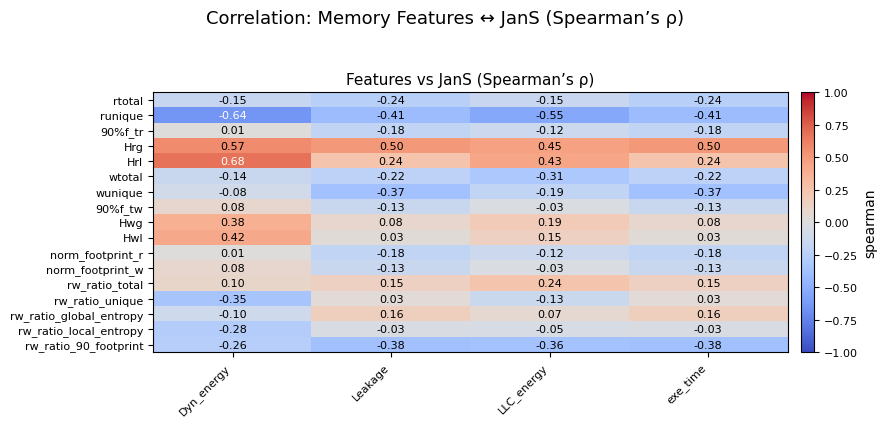

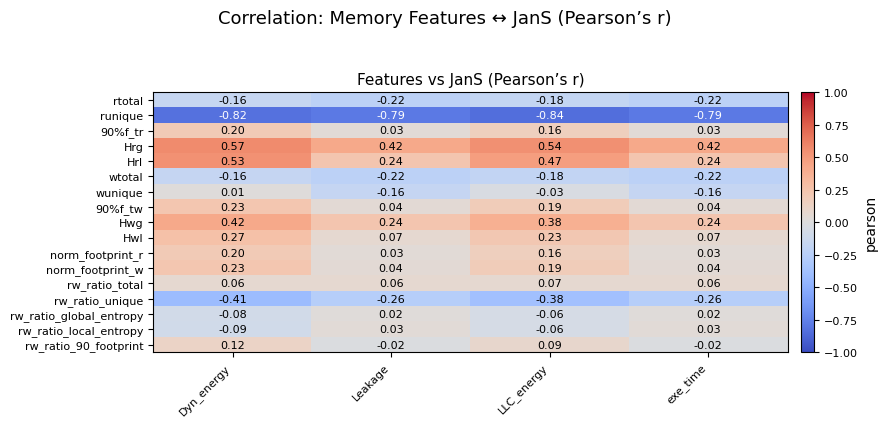

In [12]:
# Correlate DynamoRIO memory features vs JanS energy/time (Sniper)
# Adds to Y-axis:
#   read_intensity = rtotal / instructions
#   write_intensity = wtotal / instructions
#   norm_footprint_r = 90%f_tr / LLC_size_in_lines
#   norm_footprint_w = 90%f_tw / LLC_size_in_lines
#
# NOTE: Set LLC sizing below if different from defaults.

import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Paths & run-specific knobs
# -----------------------------
SNIPER_RESULTS_DIR = "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z"
DYNAMORIO_LOGS_DIR = "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
TIMESTAMP_PREFIX = "20250929T203551Z"  # prefix used in DynamoRIO filenames

# --- LLC sizing (edit if needed) ---
LLC_SIZE_BYTES = 32 * 1024 * 1024       # 32MB default
LLC_LINE_SIZE_BYTES = 64                 # 64B default
LLC_size_in_lines = float(LLC_SIZE_BYTES) / float(LLC_LINE_SIZE_BYTES)

# -----------------------------
# Utilities
# -----------------------------
def safe_div(numer, denom):
    numer = np.array(numer, dtype=float)
    denom = np.array(denom, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = np.where((denom > 0) & np.isfinite(denom), numer / denom, np.nan)
    return out

def geomean(values):
    vals = np.array([v for v in np.ravel(values) if v > 0 and np.isfinite(v)], dtype=float)
    return float(np.exp(np.mean(np.log(vals)))) if len(vals) else np.nan

# -----------------------------
# Parsing helpers (Sniper & DynamoRIO)
# -----------------------------
def parse_sniper(base_dir):
    """
    Walk output_* folders, read summary.csv and energy_bounds.csv,
    merge them on (benchmark, config). Return a tidy DataFrame.
    """
    energy_rows = []
    summary_rows = []
    print(f"[parse_sniper] Searching under: {base_dir}")
    for root, _, files in os.walk(base_dir):
        if os.path.basename(root).startswith("output_") and "summary.csv" in files and "energy_bounds.csv" in files:
            energy_path = os.path.join(root, "energy_bounds.csv")
            summary_path = os.path.join(root, "summary.csv")
            try:
                e = pd.read_csv(energy_path)
                s = pd.read_csv(summary_path)
            except Exception:
                continue

            # Keep relevant cols if present
            e_keep = ["benchmark", "config", "time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]
            e = e[[c for c in e_keep if c in e.columns]].copy()
            s_base = ["benchmark", "config", "ipc", "time_ns", "l3_miss_rate_pct"]
            keep_s = [c for c in s_base if c in s.columns]

            # Also keep any LLC/l3 counters (best-effort)
            for col in s.columns:
                cl = col.lower()
                if ("l3" in cl or "llc" in cl) and (
                    "access" in cl or "read" in cl or "write" in cl or "hit" in cl or "miss" in cl or "evict" in cl or "wb" in cl
                ):
                    if col not in keep_s:
                        keep_s.append(col)
            s = s[keep_s].copy()

            # Numeric coercion
            for col in ["time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]:
                if col in e.columns:
                    e[col] = pd.to_numeric(e[col], errors="coerce")
            for col in s.columns:
                if col not in ("benchmark", "config"):
                    s[col] = pd.to_numeric(s[col], errors="coerce")

            if "dyn_exact_nJ" in e.columns:
                e["dyn_exact_J"] = e["dyn_exact_nJ"] * 1e-9

            energy_rows.append(e)
            summary_rows.append(s)

    if not energy_rows or not summary_rows:
        raise FileNotFoundError(f"Could not find summary.csv and energy_bounds.csv under: {base_dir}")

    E = pd.concat(energy_rows, ignore_index=True)
    S = pd.concat(summary_rows, ignore_index=True)
    df = pd.merge(E, S, on=["benchmark", "config"], how="inner")
    df = df.dropna(subset=["benchmark", "config", "time_s", "energy_exact_J"])
    print(f"[parse_sniper] Merged DataFrame shape: {df.shape}")
    return df

def _kv_from_line(s: str) -> dict:
    kv = {}
    m = re.search(r"\bscope=(\w+)", s)
    if m:
        kv["scope"] = m.group(1)
    for k, v in re.findall(r"([A-Za-z0-9_]+)=([+\-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+\-]?\d+)?|nan)", s):
        try:
            kv[k] = float("nan") if v.lower() == "nan" else float(v)
        except Exception:
            pass
    return kv

def parse_dynamorio(logs_dir, ts_prefix):
    """
    Parse DynamoRIO log files by aggregating *per-interval* rows correctly.

    - Considers only lines with scope=interval or scope=final.
    - Sums per-interval totals (read_total/write_total).
    - Weighted-averages entropies & 90% footprints by the corresponding op totals.
    - Uses the last snapshot for cumulative fields (reads, writes, bytes_*, global_footprint_bytes, *_unique_lines).
    - Sets read_unique/write_unique to final *_unique_lines if available, else max( per-interval read_unique/write_unique ).
    - For instrs/instructions: choose max(sum over intervals, last snapshot).

    File name format: {ts_prefix}_<benchmark>_instr.rwstats.log
    """
    rows = []
    print(f"[parse_dynamorio] Searching logs: {logs_dir} (prefix={ts_prefix})")
    if not os.path.isdir(logs_dir):
        print("[parse_dynamorio] Logs dir not found; returning empty DataFrame.")
        return pd.DataFrame()

    # Keys we will aggregate/use
    r_weight_keys = {"read_entropy", "read_local_entropy", "read_footprint90L"}
    w_weight_keys = {"write_entropy", "write_local_entropy", "write_footprint90L"}
    cumulative_last_keys = [
        "reads", "writes", "bytes_read", "bytes_written",
        "global_footprint_bytes", "read_unique_lines", "write_unique_lines",
    ]
    max_keys = ["read_unique", "write_unique", "uniq_lines", "uniq_pages", "footprint_bytes"]

    found = 0
    for fname in os.listdir(logs_dir):
        if not (fname.startswith(ts_prefix) and fname.endswith("_instr.rwstats.log")):
            continue
        m = re.match(rf"{re.escape(ts_prefix)}_(.+?)_instr\.rwstats\.log$", fname)
        if not m:
            continue
        found += 1
        benchmark = m.group(1)
        fpath = os.path.join(logs_dir, fname)

        # Collect relevant interval-like rows only
        ivals = []
        try:
            with open(fpath, "r", errors="ignore") as f:
                for line in f:
                    if "scope=" not in line:
                        continue
                    kv = _kv_from_line(line.strip())
                    if not kv:
                        continue
                    sc = str(kv.get("scope", "")).lower()
                    if sc in ("interval", "final"):  # treat 'final' like one more interval
                        ivals.append(kv)
        except Exception:
            continue

        if not ivals:
            continue

        # Prepare weights: prefer explicit per-interval totals; else fall back to deltas of cumulative counters
        reads_seq = [r.get("reads", np.nan) for r in ivals]
        writes_seq = [r.get("writes", np.nan) for r in ivals]
        # deltas (first interval delta unknown -> NaN)
        dreads = [np.nan]
        dwrites = [np.nan]
        for i in range(1, len(ivals)):
            a, b = reads_seq[i-1], reads_seq[i]
            c, d = writes_seq[i-1], writes_seq[i]
            dreads.append((b - a) if (np.isfinite(a) and np.isfinite(b) and b >= a) else np.nan)
            dwrites.append((d - c) if (np.isfinite(c) and np.isfinite(d) and d >= c) else np.nan)

        r_wts = []
        w_wts = []
        for i, r in enumerate(ivals):
            rtot = r.get("read_total", np.nan)
            wtot = r.get("write_total", np.nan)
            r_wts.append(rtot if np.isfinite(rtot) else dreads[i])
            w_wts.append(wtot if np.isfinite(wtot) else dwrites[i])

        # Aggregate totals
        sum_read_total = float(np.nansum([w for w in r_wts if np.isfinite(w)])) if any(np.isfinite(w) for w in r_wts) else np.nan
        sum_write_total = float(np.nansum([w for w in w_wts if np.isfinite(w)])) if any(np.isfinite(w) for w in w_wts) else np.nan

        # Weighted averages
        agg = {"benchmark": benchmark, "scope": "aggregate"}
        agg["read_total"] = sum_read_total
        agg["write_total"] = sum_write_total

        def _wavg(keys, weights, which):
            den = float(np.nansum([w for w in weights if np.isfinite(w)]))
            for k in keys:
                num = 0.0
                if den > 0:
                    for i, row in enumerate(ivals):
                        v = row.get(k, np.nan)
                        w = weights[i]
                        if np.isfinite(v) and np.isfinite(w) and w > 0:
                            num += v * w
                    agg[k] = num / den if den > 0 else np.nan
                else:
                    agg[k] = np.nan

        _wavg(r_weight_keys, r_wts, "read")
        _wavg(w_weight_keys, w_wts, "write")

        # Last-snapshot cumulative fields
        for k in cumulative_last_keys:
            for row in reversed(ivals):
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    agg[k] = v
                    break

        # Unique counts: prefer *_unique_lines (cumulative), else max per-interval unique
        if np.isfinite(agg.get("read_unique_lines", np.nan)):
            agg["read_unique"] = agg["read_unique_lines"]
        else:
            rmax = np.nan
            for row in ivals:
                v = row.get("read_unique", np.nan)
                if np.isfinite(v):
                    rmax = v if not np.isfinite(rmax) else max(rmax, v)
            if np.isfinite(rmax):
                agg["read_unique"] = rmax

        if np.isfinite(agg.get("write_unique_lines", np.nan)):
            agg["write_unique"] = agg["write_unique_lines"]
        else:
            wmax = np.nan
            for row in ivals:
                v = row.get("write_unique", np.nan)
                if np.isfinite(v):
                    wmax = v if not np.isfinite(wmax) else max(wmax, v)
            if np.isfinite(wmax):
                agg["write_unique"] = wmax

        # Max-type fields for reference (not critical to current feature map)
        for k in ["read_unique", "write_unique", "uniq_lines", "uniq_pages", "footprint_bytes"]:
            vmax = np.nan
            for row in ivals:
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    vmax = v if not np.isfinite(vmax) else max(vmax, v)
            if np.isfinite(vmax):
                agg[k] = vmax

        # Instructions: choose max(sum of per-interval, last snapshot)
        for k in ("instrs", "instructions"):
            s = float(np.nansum([row.get(k, np.nan) for row in ivals if np.isfinite(row.get(k, np.nan))]))
            lastv = np.nan
            for row in reversed(ivals):
                v = row.get(k, np.nan)
                if np.isfinite(v):
                    lastv = v
                    break
            if np.isfinite(s) or np.isfinite(lastv):
                agg[k] = max(s if np.isfinite(s) else -np.inf, lastv if np.isfinite(lastv) else -np.inf)

        rows.append(agg)

    print(f"[parse_dynamorio] Processed {found} files; rows={len(rows)}")
    return pd.DataFrame(rows)

# -----------------------------
# Plot helper (compact heatmap)
# -----------------------------
def corr_heatmap(ax, matrix, row_labels, col_labels, title):
    im = ax.imshow(matrix, aspect="auto", vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha="right")
    ax.set_title(title, fontsize=11)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                        color="white" if abs(val) > 0.6 else "black", fontsize=8)
    return im

# -----------------------------
# Main (compact correlation-only)
# -----------------------------
def main():
    out_dir = os.getcwd()

    # Load data
    sniper = parse_sniper(SNIPER_RESULTS_DIR)
    dr = parse_dynamorio(DYNAMORIO_LOGS_DIR, TIMESTAMP_PREFIX)

    # Save raw (light)
    sniper.to_csv(os.path.join(out_dir, "sniper_raw.csv"), index=False)
    if not dr.empty:
        dr.to_csv(os.path.join(out_dir, "dynamorio_raw.csv"), index=False)

    # Focus on SRAM & JanS
    sram = sniper[sniper["config"] == "SRAM"].set_index("benchmark")
    jans = sniper[sniper["config"] == "JanS"].set_index("benchmark")
    common = sram.index.intersection(jans.index)
    if len(common) < 2:
        raise RuntimeError("Need at least 2 common benchmarks between SRAM and JanS for correlations.")

    # stable ordering (sort by SRAM time)
    order = sram.loc[common].sort_values("time_s").index.tolist()
    sram = sram.loc[order]
    jans = jans.loc[order]
    labels = order

    # DynamoRIO features mapping (concise)
    feat_map = {
        "rtotal": "read_total",
        "runique": "read_unique",
        "90%f_tr": "read_footprint90L",
        "Hrg": "read_entropy",
        "Hrl": "read_local_entropy",
        "wtotal": "write_total",
        "wunique": "write_unique",
        "90%f_tw": "write_footprint90L",
        "Hwg": "write_entropy",
        "Hwl": "write_local_entropy",
    }

    if dr.empty:
        raise RuntimeError("DynamoRIO data not found — cannot compute correlations.")

    feats = pd.DataFrame({"benchmark": dr["benchmark"]})
    for out_name, src in feat_map.items():
        feats[out_name] = pd.to_numeric(dr.get(src), errors="coerce")
    feats = feats.set_index("benchmark")

    # Add intensity features if instruction column exists
    dr_idx = dr.set_index("benchmark")
    instr_col = 'instrs' if 'instrs' in dr_idx.columns else ('instructions' if 'instructions' in dr_idx.columns else None)
    if instr_col:
        instr_count = pd.to_numeric(dr_idx[instr_col], errors='coerce')
        feats['read_intensity'] = safe_div(feats.get('rtotal'), instr_count)
        feats['write_intensity'] = safe_div(feats.get('wtotal'), instr_count)

    # Normalized 90% footprints by LLC size (in lines)
    feats['norm_footprint_r'] = safe_div(feats.get('90%f_tr'), LLC_size_in_lines)
    feats['norm_footprint_w'] = safe_div(feats.get('90%f_tw'), LLC_size_in_lines)

    # ratio features
    feats['rw_ratio_total'] = safe_div(feats.get('rtotal'), feats.get('wtotal'))
    feats['rw_ratio_unique'] = safe_div(feats.get('runique'), feats.get('wunique'))
    feats['rw_ratio_global_entropy'] = safe_div(feats.get('Hrg'), feats.get('Hwg'))
    feats['rw_ratio_local_entropy'] = safe_div(feats.get('Hrl'), feats.get('Hwl'))
    feats['rw_ratio_90_footprint'] = safe_div(feats.get('90%f_tr'), feats.get('90%f_tw'))

    # JanS targets: exactly as requested (dyn, leak, total, time)
    targets_jans = jans[["dyn_exact_J", "leak_J", "energy_exact_J", "time_s"]].copy()
    targets_jans = targets_jans.rename(columns={
        "dyn_exact_J": "Dyn_energy",
        "leak_J": "Leakage",
        "energy_exact_J": "LLC_energy",
        "time_s": "exe_time",
    })

    # Join features with targets
    corr_df = feats.join(targets_jans, how="inner")
    corr_df = corr_df.loc[corr_df.index.intersection(labels)]
    corr_df = corr_df.reindex(labels)

    if corr_df.shape[0] < 2:
        raise RuntimeError("Not enough overlapping benchmarks after join to compute correlations.")

    # Candidate features (keep only those present with some data)
    candidate_features = [
        "rtotal","runique","90%f_tr","Hrg","Hrl",
        "wtotal","wunique","90%f_tw","Hwg","Hwl",
        "read_intensity","write_intensity",
        "norm_footprint_r","norm_footprint_w",
        "rw_ratio_total","rw_ratio_unique",
        "rw_ratio_global_entropy","rw_ratio_local_entropy","rw_ratio_90_footprint"
    ]
    feature_names = [f for f in candidate_features if f in corr_df.columns and not corr_df[f].isna().all()]

    jan_cols = ["Dyn_energy", "Leakage", "LLC_energy", "exe_time"]
    jan_cols = [c for c in jan_cols if c in corr_df.columns and not corr_df[c].isna().all()]

    if not feature_names or not jan_cols:
        raise RuntimeError("Missing features or JanS target columns for correlation.")

    # Save the joined input for transparency
    corr_df.to_csv(os.path.join(out_dir, "corr_input_joined.csv"))

    # Compute correlations and plot heatmaps for Spearman & Pearson
    methods = [("spearman", "Spearman\u2019s \u03c1"), ("pearson", "Pearson\u2019s r")]
    saved_mats = {}
    plt.rcParams.update({
        "figure.figsize": (10, max(4, 0.25 * len(feature_names))),
        "axes.titlesize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    })

    for method, pretty in methods:
        M = corr_df[feature_names + jan_cols].corr(method=method).loc[feature_names, jan_cols].values
        dfmat = pd.DataFrame(M, index=feature_names, columns=jan_cols)
        saved_mats[method] = dfmat
        # figure
        fig, ax = plt.subplots(1, 1, figsize=(9, max(4, 0.25 * len(feature_names))))
        im = corr_heatmap(ax, M, feature_names, jan_cols, f"Features vs JanS ({pretty})")
        cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
        cbar.set_label(method)
        fig.suptitle(f"Correlation: Memory Features \u2194 JanS ({pretty})", y=0.995, fontsize=13)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        fig.savefig(os.path.join(out_dir, f"corr_heatmap_{method}.png"), dpi=200, bbox_inches="tight")

    # Save matrices
    for m, dfmat in saved_mats.items():
        dfmat.to_csv(os.path.join(out_dir, f"corr_matrix_{m}.csv"))

    print("\nSaved correlation artifacts to:", out_dir)
    print("Features used:", feature_names)
    print("JanS targets:", jan_cols)
    print(f"LLC_size_in_lines={LLC_size_in_lines:.0f} (LLC_SIZE_BYTES={LLC_SIZE_BYTES}, LINE_SIZE={LLC_LINE_SIZE_BYTES})")

    plt.show()

if __name__ == "__main__":
    main()


In [13]:
# ===========================
# Hybrid SRAM↔JanS WHAT-IF (benchmark-level stitching) -- robust version
# ===========================
print("\n[what_if] Starting SRAM↔JanS hybrid what-if (benchmark-level stitching)…")

# --- Ensure we have LLC_size_in_lines available (fallbacks if needed)
try:
    _ = LLC_size_in_lines  # already defined above
except NameError:
    try:
        LLC_size_in_lines = float(LLC_SIZE_BYTES) / float(LLC_LINE_SIZE_BYTES)
        print(f"[what_if] Using existing LLC constants: LLC_size_in_lines={LLC_size_in_lines:.0f}")
    except Exception:
        # Try to infer size from SNIPER_RESULTS_DIR name (e.g., .../sniper_llc_32mb_16w_... )
        _guessed_mb = 32.0
        try:
            _path = SNIPER_RESULTS_DIR
            _m = re.search(r'_(\d+)(mb|MB)_', _path)
            if _m:
                _guessed_mb = float(_m.group(1))
        except Exception:
            pass
        LLC_SIZE_BYTES = int(_guessed_mb * (1024**2))
        LLC_LINE_SIZE_BYTES = 64
        LLC_size_in_lines = float(LLC_SIZE_BYTES) / float(LLC_LINE_SIZE_BYTES)
        print(f"[what_if] Fallback: inferred {int(_guessed_mb)}MB from path or default; "
              f"LLC_size_in_lines={LLC_size_in_lines:.0f}")

# --- Safe-div in case block runs standalone
try:
    _ = safe_div
except NameError:
    def safe_div(numer, denom):
        numer = np.array(numer, dtype=float)
        denom = np.array(denom, dtype=float)
        with np.errstate(divide='ignore', invalid='ignore'):
            out = np.where((denom > 0) & np.isfinite(denom), numer / denom, np.nan)
        return out

ARTIFACT_DIR = os.getcwd()
SNIPER_CSV = os.path.join(ARTIFACT_DIR, "sniper_raw.csv")
DR_CSV     = os.path.join(ARTIFACT_DIR, "dynamorio_raw.csv")

if not (os.path.isfile(SNIPER_CSV) and os.path.isfile(DR_CSV)):
    raise FileNotFoundError(
        f"[what_if] Missing artifacts; expected:\n  {SNIPER_CSV}\n  {DR_CSV}\n"
        "Run the correlation script above first to produce them."
    )

# ---- Load artifacts
sn = pd.read_csv(SNIPER_CSV)
dr_raw = pd.read_csv(DR_CSV)

# Keep only JanS and SRAM rows from Sniper
sn = sn[sn["config"].isin(["SRAM", "JanS"])].copy()
need_cols = ["benchmark", "config", "time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"]
missing = [c for c in need_cols if c not in sn.columns]
if missing:
    raise ValueError(f"[what_if] sniper_raw.csv missing columns: {missing}")

# Wide table: per-benchmark measured outcomes for each device
wide = sn.pivot_table(index="benchmark", columns="config",
                      values=["time_s", "energy_exact_J", "leak_J", "dyn_exact_nJ"])
wide.columns = [f"{a}_{b}" for a, b in wide.columns]

# Compute ED²P per device at the benchmark level
for dev in ["SRAM", "JanS"]:
    if f"time_s_{dev}" in wide and f"energy_exact_J_{dev}" in wide:
        wide[f"ED2P_{dev}"] = wide[f"energy_exact_J_{dev}"] * (wide[f"time_s_{dev}"] ** 2)

# ---- Features (benchmark-level)
dr_idx = dr_raw.set_index("benchmark").copy()

# Harmonize column names used in rules
col_alias = {
    "read_total": "rtotal",
    "write_total": "wtotal",
    "read_local_entropy": "Hrl",
    "write_local_entropy": "Hwl",
    "read_footprint90L": "fp_r",
    "write_footprint90L": "fp_w",
    "instructions": "instrs",
}
for src, dst in col_alias.items():
    if src in dr_idx.columns and dst not in dr_idx.columns:
        dr_idx[dst] = pd.to_numeric(dr_idx[src], errors="coerce")
# If shorthand already exist, leave as-is
for short in ["rtotal", "wtotal", "Hrl", "Hwl", "fp_r", "fp_w", "instrs"]:
    if short not in dr_idx.columns:
        dr_idx[short] = pd.NA

# Intensities and normalized footprints
dr_idx["read_fraction"] = safe_div(dr_idx["rtotal"], (dr_idx["rtotal"] + dr_idx["wtotal"]))
dr_idx["read_intensity"] = safe_div(dr_idx["rtotal"], dr_idx["instrs"])
dr_idx["write_intensity"] = safe_div(dr_idx["wtotal"], dr_idx["instrs"])
dr_idx["norm_fp_r"] = safe_div(dr_idx["fp_r"], LLC_size_in_lines)
dr_idx["norm_fp_w"] = safe_div(dr_idx["fp_w"], LLC_size_in_lines)

# ---- Merge features with device outcomes
df = wide.join(dr_idx, how="inner")
df = df.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["time_s_SRAM", "time_s_JanS", "energy_exact_J_SRAM", "energy_exact_J_JanS"], how="any"
)

if df.empty:
    raise RuntimeError("[what_if] No overlap between Sniper outcomes and DynamoRIO features.")

# ---- Thresholds (percentile-based; tweak if desired)
CAP_MB = float(LLC_SIZE_BYTES) / (1024.0 * 1024.0)
is_small_cache = CAP_MB <= 4.0   # treat ≤4MB as 'small' (your cases: 2MB vs 32MB)

def pct(s, p):
    try:
        return float(np.nanpercentile(pd.to_numeric(s, errors="coerce"), p))
    except Exception:
        return np.nan

Hrl_THR = pct(df["Hrl"], 60)            # read-local irregularity threshold
READ_FRAC_THR = 0.60                    # read-heavy if ≥ 60% reads
FP_R_THR = pct(df["norm_fp_r"], 50)     # median normalized 90% read footprint
FP_W_THR = pct(df["norm_fp_w"], 50)     # median normalized 90% write footprint

PERF_CAP = 1.03     # slowdown guardrail: at most +3% vs SRAM for any benchmark

# ---- Decision rule (coarse; benchmark-level)
choices = []
reasons = []
for bmk, row in df.iterrows():
    # Default selection by capacity regime
    if is_small_cache:
        # 2MB rule-of-thumb
        if pd.notna(row["Hrl"]) and row["Hrl"] >= Hrl_THR:
            pick = "SRAM"; reason = f"Hrl={row['Hrl']:.2f}≥{Hrl_THR:.2f}"
        elif pd.notna(row["read_fraction"]) and pd.notna(row["norm_fp_r"]) and \
             (row["read_fraction"] >= READ_FRAC_THR) and (row["norm_fp_r"] >= FP_R_THR):
            pick = "JanS"; reason = f"read_frac={row['read_fraction']:.2f}≥{READ_FRAC_THR} & norm_fp_r={row['norm_fp_r']:.3f}≥{FP_R_THR:.3f}"
        else:
            pick = "SRAM"; reason = "default_small"
    else:
        # 32MB rule-of-thumb
        if pd.notna(row["norm_fp_w"]) and (row["norm_fp_w"] >= FP_W_THR):
            pick = "SRAM"; reason = f"norm_fp_w={row['norm_fp_w']:.3f}≥{FP_W_THR:.3f}"
        elif pd.notna(row["read_fraction"]) and pd.notna(row["Hrl"]) and \
             (row["read_fraction"] >= READ_FRAC_THR) and (row["Hrl"] < Hrl_THR):
            pick = "JanS"; reason = f"read_frac={row['read_fraction']:.2f}≥{READ_FRAC_THR} & Hrl={row['Hrl']:.2f}<{Hrl_THR:.2f}"
        else:
            pick = "SRAM"; reason = "default_large"

    # ---- Perf guardrail: if JanS would slow down too much, override to SRAM
    if pick == "JanS":
        tr = row["time_s_JanS"] / row["time_s_SRAM"] if row["time_s_SRAM"] > 0 else np.inf
        if not np.isfinite(tr) or (tr > PERF_CAP):
            reason += f"; guardrail override (time_ratio={tr:.3f}> {PERF_CAP})"
            pick = "SRAM"

    choices.append(pick)
    reasons.append(reason)

df["hybrid_pick"] = choices
df["hybrid_reason"] = reasons

# ---- Compute hybrid totals (sum across benchmarks; report also geomeans of ratios)
def bench_totals(dev_col_prefix):
    T = df[f"time_s_{dev_col_prefix}"].sum()
    E = df[f"energy_exact_J_{dev_col_prefix}"].sum()
    ED2P = (df[f"energy_exact_J_{dev_col_prefix}"] * (df[f"time_s_{dev_col_prefix}"] ** 2)).sum()
    return T, E, ED2P

T_SRAM, E_SRAM, ED2P_SRAM = bench_totals("SRAM")
T_JANS, E_JANS, ED2P_JANS = bench_totals("JanS")

# Hybrid pick per benchmark
df["time_s_hybrid"] = np.where(df["hybrid_pick"] == "JanS", df["time_s_JanS"], df["time_s_SRAM"])
df["energy_hybrid"] = np.where(df["hybrid_pick"] == "JanS", df["energy_exact_J_JanS"], df["energy_exact_J_SRAM"])
df["ED2P_hybrid"]   = df["energy_hybrid"] * (df["time_s_hybrid"] ** 2)

T_HYB = df["time_s_hybrid"].sum()
E_HYB = df["energy_hybrid"].sum()
ED2P_HYB = df["ED2P_hybrid"].sum()

# Per-benchmark ratios (for geomeans)
df["time_ratio_J_over_S"]   = safe_div(df["time_s_JanS"],   df["time_s_SRAM"])
df["energy_ratio_J_over_S"] = safe_div(df["energy_exact_J_JanS"], df["energy_exact_J_SRAM"])
df["ed2p_ratio_J_over_S"]   = safe_div(df["ED2P_JanS"], df["ED2P_SRAM"])

df["time_ratio_H_over_S"]   = safe_div(df["time_s_hybrid"],   df["time_s_SRAM"])
df["energy_ratio_H_over_S"] = safe_div(df["energy_hybrid"],    df["energy_exact_J_SRAM"])
df["ed2p_ratio_H_over_S"]   = safe_div(df["ED2P_hybrid"],      df["ED2P_SRAM"])

def geomean(values):
    vals = np.array([v for v in np.ravel(values) if v > 0 and np.isfinite(v)], dtype=float)
    return float(np.exp(np.mean(np.log(vals)))) if len(vals) else np.nan

geo = {}
for k in ["time_ratio_J_over_S", "energy_ratio_J_over_S", "ed2p_ratio_J_over_S",
          "time_ratio_H_over_S", "energy_ratio_H_over_S", "ed2p_ratio_H_over_S"]:
    geo[k] = geomean(df[k])

# ---- Save decisions
out_decisions = os.path.join(ARTIFACT_DIR, "hybrid_decisions.csv")
cols_out = [
    "hybrid_pick", "hybrid_reason",
    "time_s_SRAM", "time_s_JanS", "time_s_hybrid",
    "energy_exact_J_SRAM", "energy_exact_J_JanS", "energy_hybrid",
    "ED2P_SRAM", "ED2P_JanS", "ED2P_hybrid",
    "time_ratio_J_over_S", "time_ratio_H_over_S",
    "energy_ratio_J_over_S", "energy_ratio_H_over_S",
    "ed2p_ratio_J_over_S", "ed2p_ratio_H_over_S",
    "Hrl", "Hwl", "read_fraction", "norm_fp_r", "norm_fp_w", "read_intensity", "write_intensity"
]
df[cols_out].to_csv(out_decisions, index=True)
print(f"[what_if] Wrote hybrid decisions: {out_decisions}")

# ---- Print a concise summary
def pct_delta(x_new, x_base):
    return 100.0 * (x_new / x_base - 1.0) if (x_base and np.isfinite(x_base)) else np.nan

print("\n=== Hybrid What-if Summary ===")
print(f"Capacity: {float(LLC_SIZE_BYTES)/(1024*1024):.0f} MB   PERF_CAP (guardrail): {PERF_CAP*100:.0f}% of SRAM")
print(f"Pick counts: JanS={int((df['hybrid_pick']=='JanS').sum())}, SRAM={int((df['hybrid_pick']=='SRAM').sum())}, total={len(df)}")
print("\n-- Totals (sum across benchmarks) --")
print(f"Time:    SRAM={T_SRAM:.3f}s  JanS={T_JANS:.3f}s  HYB={T_HYB:.3f}s  (ΔHYB vs SRAM = {pct_delta(T_HYB,T_SRAM):+.2f}%)")
print(f"Energy:  SRAM={E_SRAM:.6f}J  JanS={E_JANS:.6f}J  HYB={E_HYB:.6f}J  (ΔHYB vs SRAM = {pct_delta(E_HYB,E_SRAM):+.2f}%)")
print(f"ED2PΣ:   SRAM={ED2P_SRAM:.6f}  JanS={ED2P_JANS:.6f}  HYB={ED2P_HYB:.6f}  (ΔHYB vs SRAM = {pct_delta(ED2P_HYB,ED2P_SRAM):+.2f}%)")

print("\n-- Geomean ratios (per-benchmark, J/S and HYB/S) --")
print(f"J/S   time={geo['time_ratio_J_over_S']:.3f}  energy={geo['energy_ratio_J_over_S']:.3f}  ed2p={geo['ed2p_ratio_J_over_S']:.3f}")
print(f"HYB/S time={geo['time_ratio_H_over_S']:.3f}  energy={geo['energy_ratio_H_over_S']:.3f}  ed2p={geo['ed2p_ratio_H_over_S']:.3f}")

# ===========================
# Optional: Prefetch guardrail A/B stitching for JanS
# ===========================
PREFETCH_ON_DIR  = os.environ.get("JANSON_DIR",  "")   # e.g., "/.../sniper_llc_32mb_16w_prefetchON_..."
PREFETCH_OFF_DIR = os.environ.get("JANSOFF_DIR", "")   # e.g., "/.../sniper_llc_32mb_16w_prefetchOFF_..."

def load_sniper_dir(d):
    if not d:
        return None
    try:
        df_ = parse_sniper(d)
        df_ = df_[df_["config"] == "JanS"][["benchmark","time_s","energy_exact_J"]].set_index("benchmark")
        return df_.rename(columns={"time_s":"time_s_JanS", "energy_exact_J":"energy_exact_J_JanS"})
    except Exception:
        return None

if PREFETCH_ON_DIR and PREFETCH_OFF_DIR:
    print("\n[what_if] Prefetch A/B detected via env vars JANSON_DIR / JANSOFF_DIR; running guardrail stitch…")
    on = load_sniper_dir(PREFETCH_ON_DIR)
    off = load_sniper_dir(PREFETCH_OFF_DIR)
    if on is not None and off is not None:
        Hrl_med = pct(df["Hrl"], 50)
        FP_R_med = pct(df["norm_fp_r"], 50)
        pick_on = (df["Hrl"] < Hrl_med) & (df["norm_fp_r"] < FP_R_med)
        jan = pd.concat({"ON": on, "OFF": off}, axis=1)
        jan = df.index.to_frame(index=False).merge(jan, left_on="benchmark", right_index=True, how="left").set_index("benchmark")
        t_gated = np.where(pick_on, jan[("ON","time_s_JanS")],  jan[("OFF","time_s_JanS")])
        e_gated = np.where(pick_on, jan[("ON","energy_exact_J_JanS")], jan[("OFF","energy_exact_J_JanS")])
        tr_vs_off = t_gated / jan[("OFF","time_s_JanS")]
        keep_off = (tr_vs_off > PERF_CAP) | ~np.isfinite(tr_vs_off)
        t_gated[keep_off] = jan[("OFF","time_s_JanS")][keep_off]
        e_gated[keep_off] = jan[("OFF","energy_exact_J_JanS")][keep_off]
        T_gated = np.nansum(t_gated); E_gated = np.nansum(e_gated)
        T_off = float(np.nansum(jan[("OFF","time_s_JanS")].values))
        E_off = float(np.nansum(jan[("OFF","energy_exact_J_JanS")].values))
        print(f"[prefetch] Gated vs OFF:  ΔTime={pct_delta(T_gated,T_off):+.2f}%,  ΔEnergy={pct_delta(E_gated,E_off):+.2f}%  "
              f"(guardrail {PERF_CAP*100:.0f}% applied)")
    else:
        print("[what_if] Prefetch A/B directories not valid; skipping.")
else:
    print("[what_if] Prefetch A/B env vars not set; skipping (set JANSON_DIR and JANSOFF_DIR to enable).")



[what_if] Starting SRAM↔JanS hybrid what-if (benchmark-level stitching)…
[what_if] Wrote hybrid decisions: /home/skataoka26/hybrid_decisions.csv

=== Hybrid What-if Summary ===
Capacity: 32 MB   PERF_CAP (guardrail): 103% of SRAM
Pick counts: JanS=4, SRAM=8, total=12

-- Totals (sum across benchmarks) --
Time:    SRAM=97.556s  JanS=96.519s  HYB=97.437s  (ΔHYB vs SRAM = -0.12%)
Energy:  SRAM=16.778545J  JanS=10.299085J  HYB=15.059640J  (ΔHYB vs SRAM = -10.24%)
ED2PΣ:   SRAM=13742.113635  JanS=8705.831932  HYB=13606.965507  (ΔHYB vs SRAM = -0.98%)

-- Geomean ratios (per-benchmark, J/S and HYB/S) --
J/S   time=0.986  energy=0.496  ed2p=0.483
HYB/S time=0.997  energy=0.765  ed2p=0.761
[what_if] Prefetch A/B env vars not set; skipping (set JANSON_DIR and JANSOFF_DIR to enable).


[parse_sniper] Searching under: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_2mb_16w_20251002T020032Z
[parse_sniper] Merged DataFrame shape: (24, 19)
[plots] Wrote bar_time_raw_2MB.png
[plots] Wrote bar_time_ratio_2MB.png
[plots] Wrote bar_energy_total_raw_2MB.png
[plots] Wrote bar_energy_total_ratio_2MB.png
[plots] Wrote bar_energy_dyn_raw_2MB.png
[plots] Wrote bar_energy_dyn_ratio_2MB.png
[plots] Wrote bar_missrate_raw_2MB.png
[plots] Wrote bar_missrate_ratio_2MB.png
[parse_sniper] Searching under: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z
[parse_sniper] Merged DataFrame shape: (24, 19)
[plots] Wrote bar_time_raw_32MB.png
[plots] Wrote bar_time_ratio_32MB.png
[plots] Wrote bar_energy_total_raw_32MB.png
[plots] Wrote bar_energy_total_ratio_32MB.png
[plots] Wrote bar_energy_dyn_raw_32MB.png
[plots] Wrote bar_energy_dyn_ratio_32MB.png
[plots] Wrote bar_missrate_raw_32MB.png
[plots] Wrote bar_missrate_ratio_32MB.png
[plots] Done.


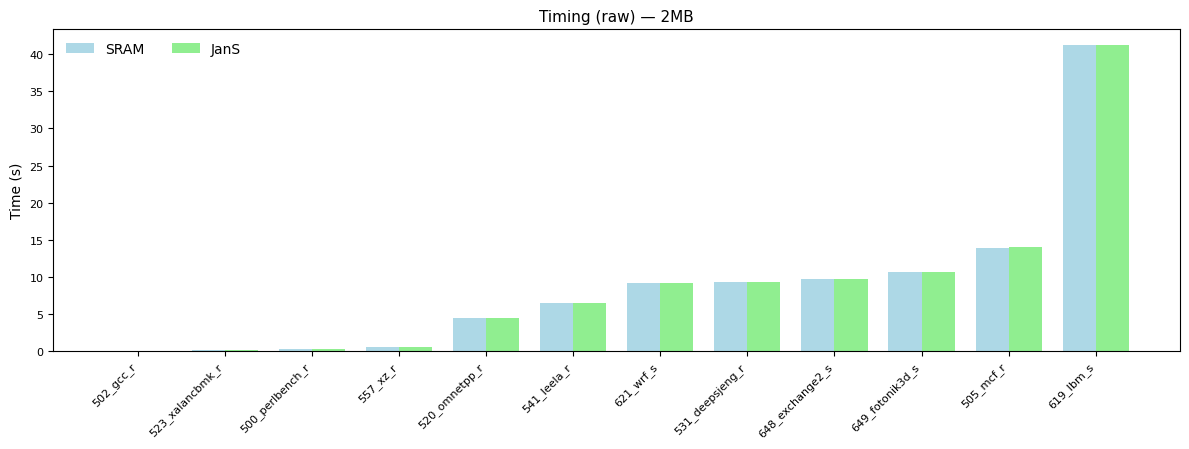

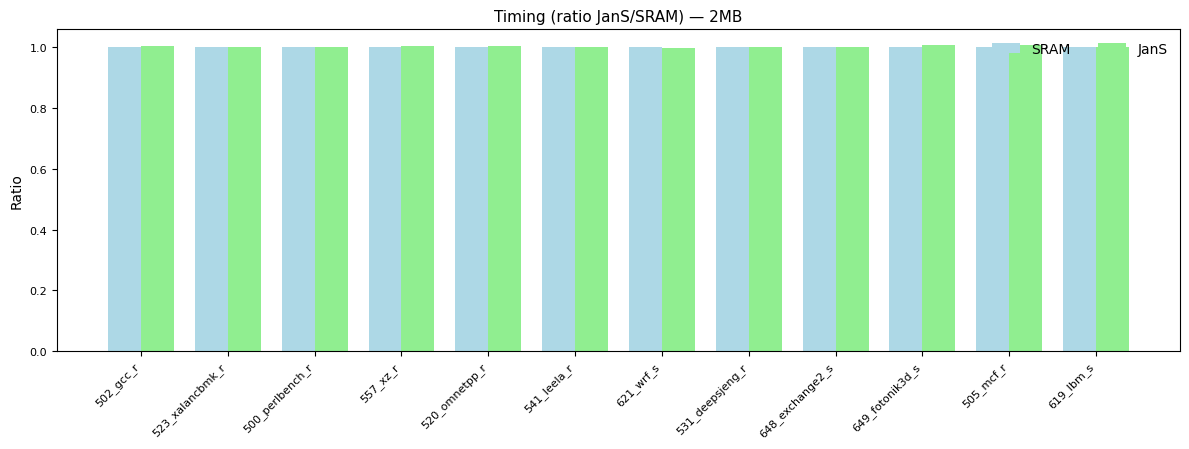

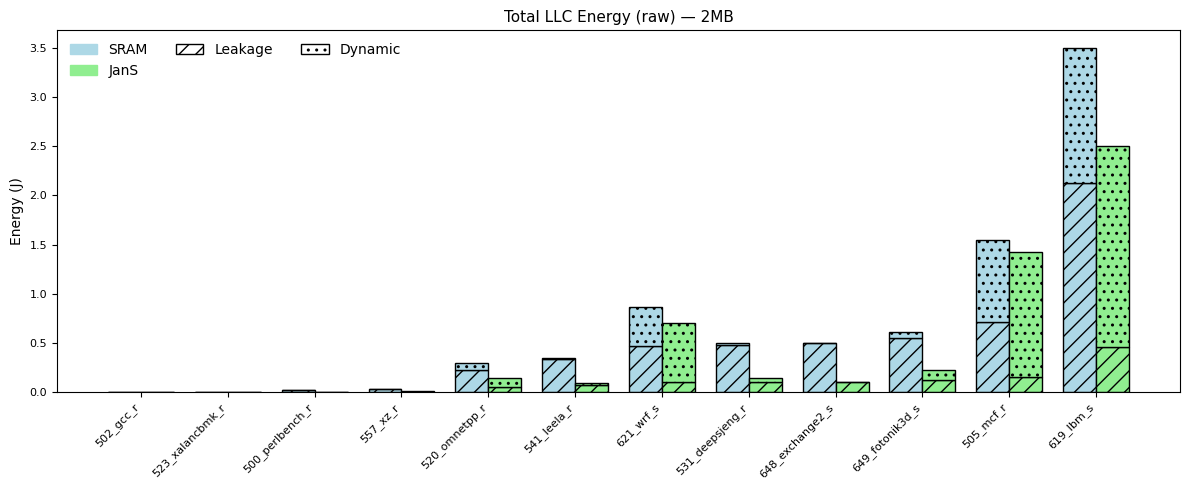

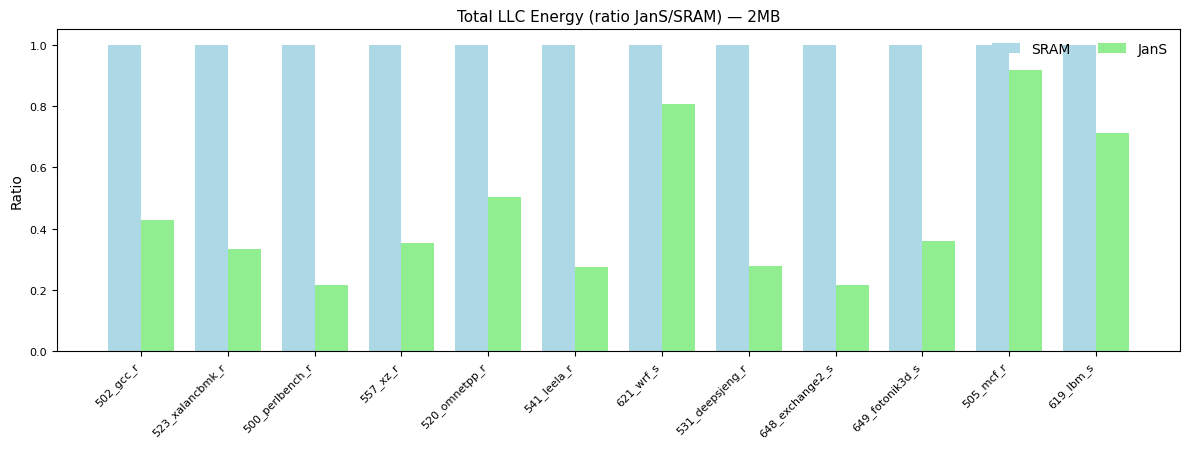

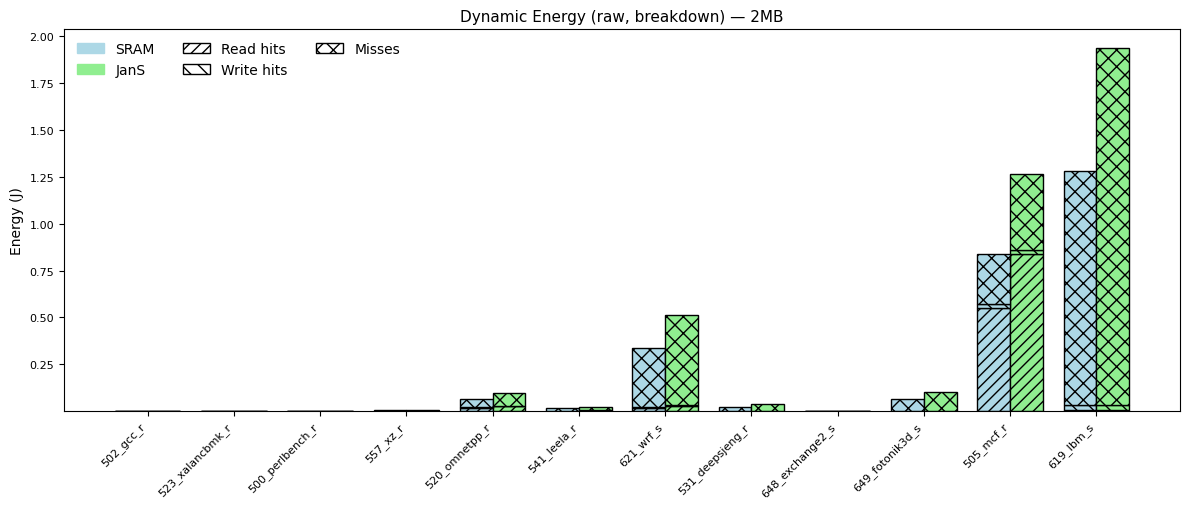

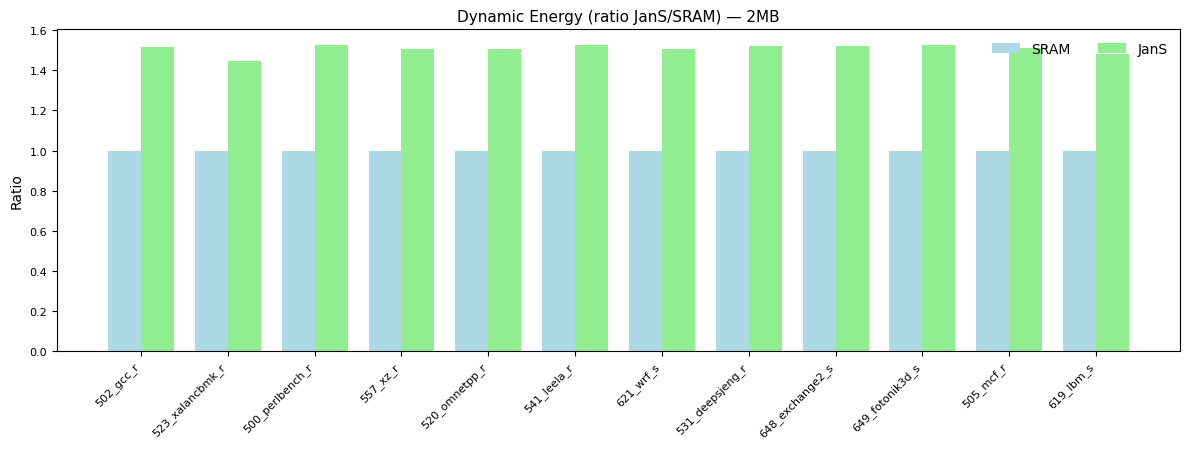

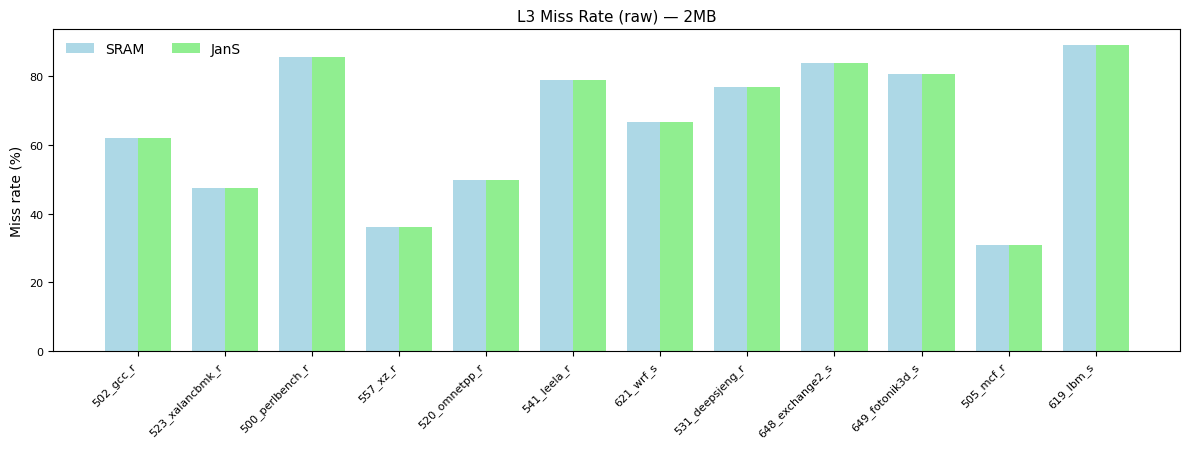

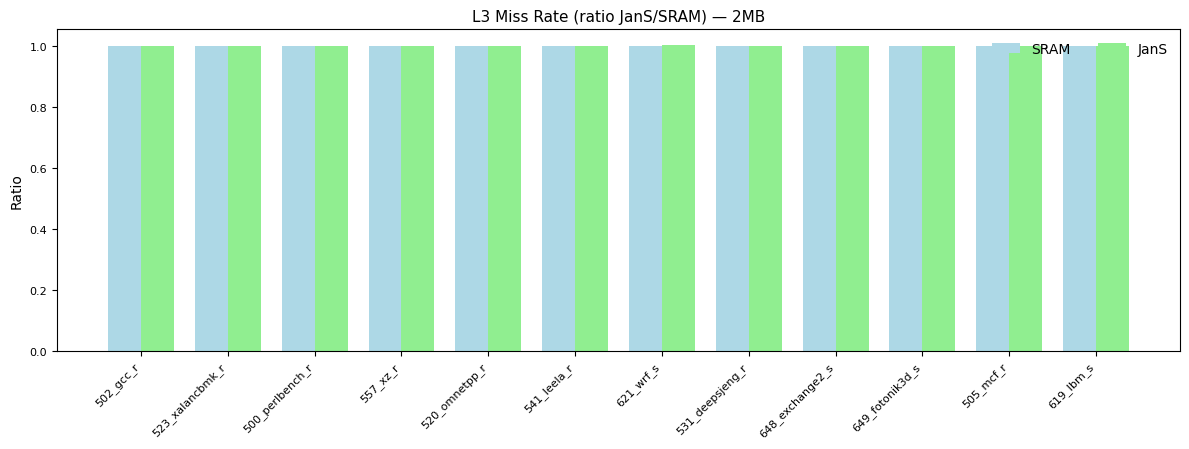

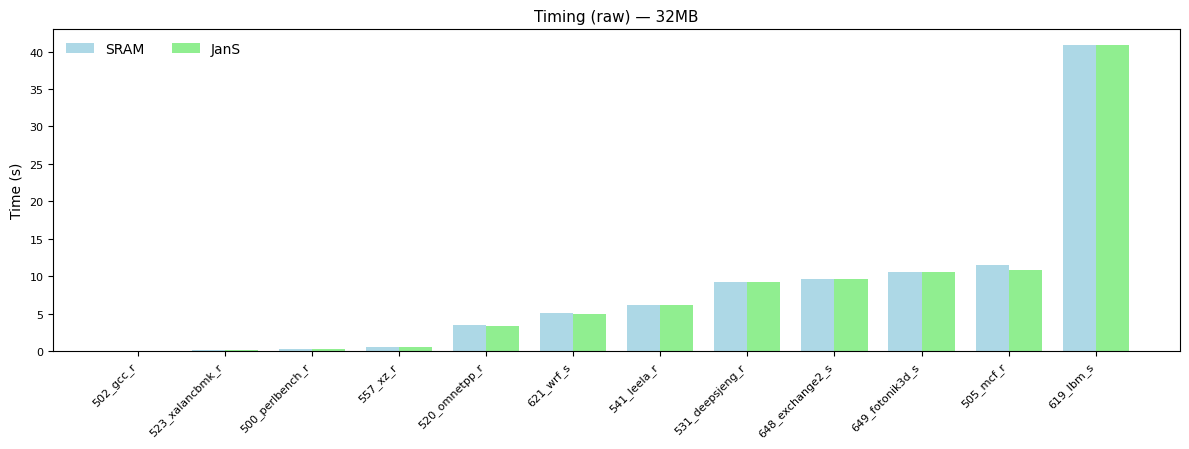

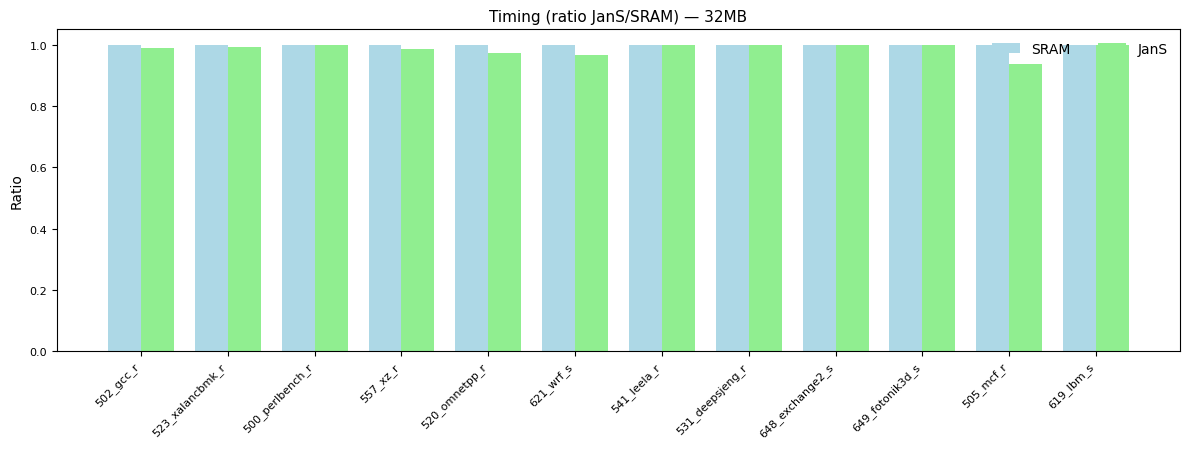

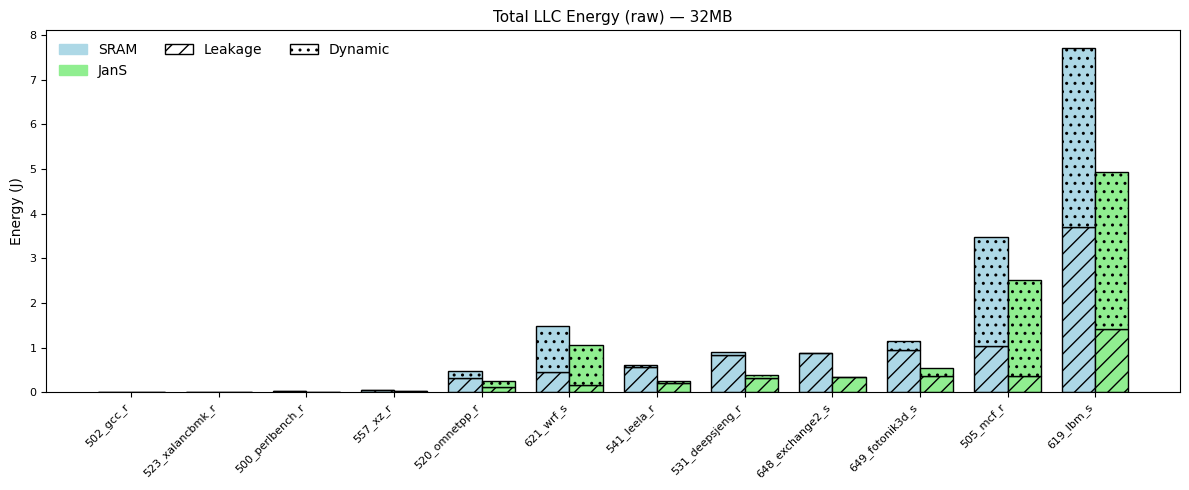

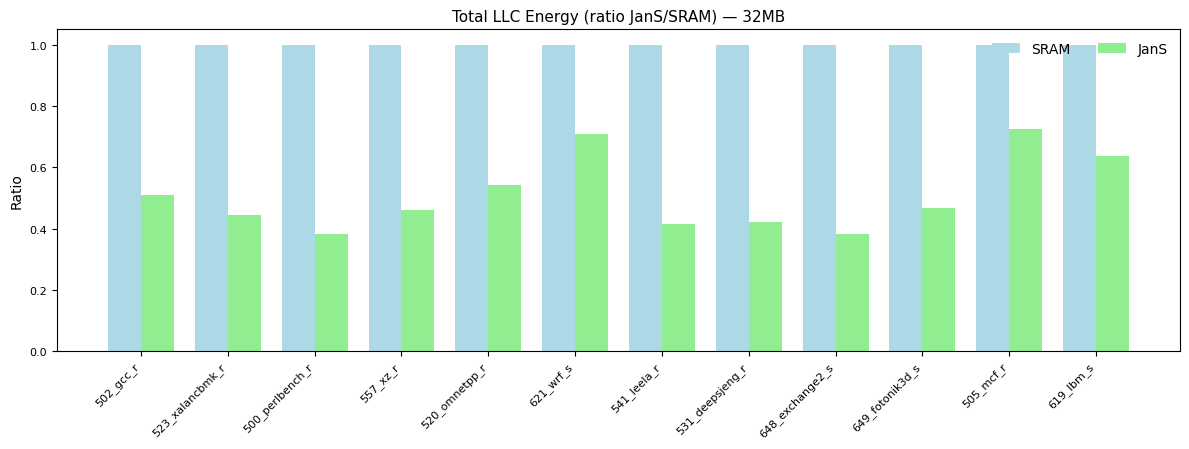

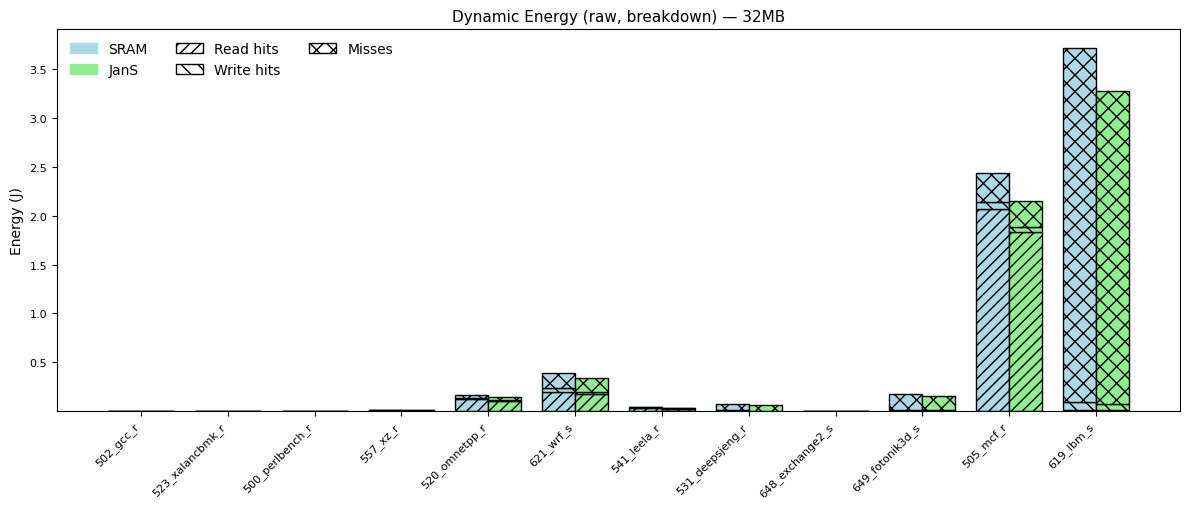

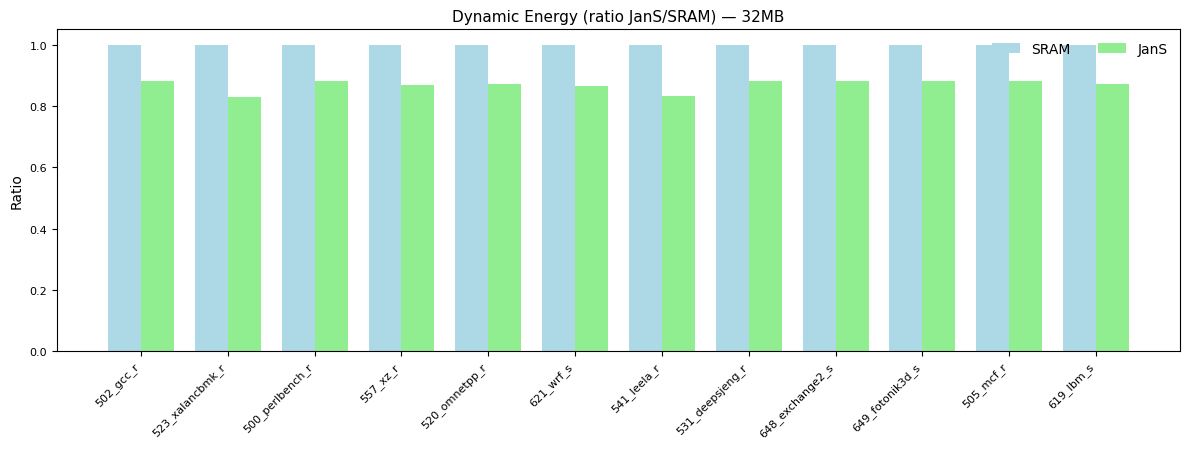

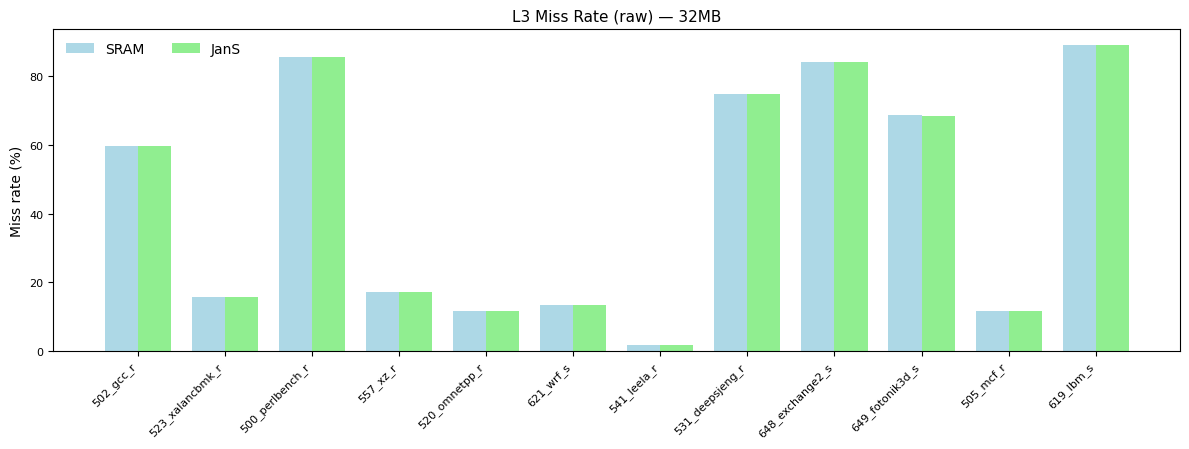

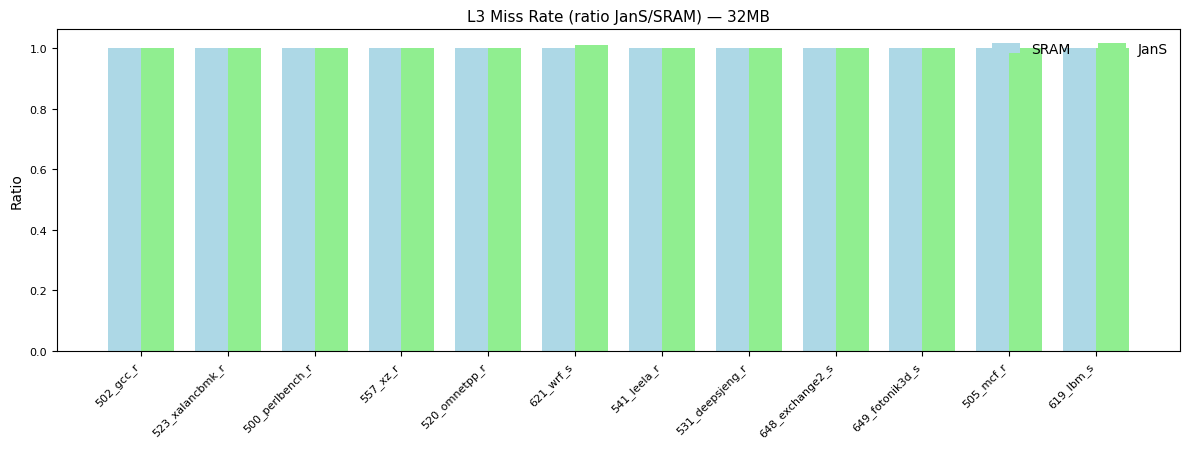

In [14]:
# ===========================
# GROUPED BAR CHARTS (2MB & 32MB)
# time, total LLC energy (Leak+Dyn stacked), dynamic energy (RH/WH/Miss stacked),
# miss rate — RAW and RATIO (JanS/SRAM)
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- EXACT result roots you specified
DIR_2MB  = "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_2mb_16w_20251002T020032Z"
DIR_32MB = "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z"

# --- Visual constants
CLR_SRAM = "#ADD8E6"  # light blue
CLR_JANS = "#90EE90"  # light green
HATCH_LEAK = "//"
HATCH_DYN  = ".."
HATCH_RH   = "///"
HATCH_WH   = "\\\\"
HATCH_MS   = "xx"

# --- Per-access energies (pJ) from your YAML
E_PJ = {
    "2MB": {
        "SRAM": {"read": 562.0,  "write": 534.0,  "miss": 562.0},
        "JanS": {"read": 859.0,  "write": 489.0,  "miss": 859.0},
    },
    "32MB": {
        "SRAM": {"read": 1650.0, "write": 1486.0, "miss": 1650.0},
        "JanS": {"read": 1458.0, "write": 1107.0, "miss": 1458.0},
    },
}
pJ2J = 1e-12

def _pivot_by_config(df, cols):
    keep = ["benchmark","config"] + [c for c in cols if c in df.columns]
    pv = df[keep].pivot_table(index="benchmark", columns="config",
                              values=[c for c in cols if c in df.columns])
    pv.columns = [f"{a}_{b}" for a,b in pv.columns]
    return pv

def _load_results(sniper_dir):
    df = parse_sniper(sniper_dir)
    df = df[df["config"].isin(["SRAM","JanS"])].copy()
    base = _pivot_by_config(df, ["time_s","energy_exact_J","leak_J","dyn_exact_nJ"])
    # dyn nJ -> dyn J
    if "dyn_exact_nJ_SRAM" in base.columns: base["dyn_exact_J_SRAM"] = pd.to_numeric(base["dyn_exact_nJ_SRAM"], errors="coerce")*1e-9
    if "dyn_exact_nJ_JanS" in base.columns: base["dyn_exact_J_JanS"] = pd.to_numeric(base["dyn_exact_nJ_JanS"], errors="coerce")*1e-9
    # best-effort counters
    l3_cols = [c for c in df.columns if c.lower().startswith("l3_")]
    prefer  = ["l3_read_hits","l3_write_hits","l3_misses_db","l3_accesses_db","l3_miss_rate_pct"]
    keep = [c for c in prefer if c in df.columns]
    for c in l3_cols:
        if c not in keep: keep.append(c)
    cnt = _pivot_by_config(df, keep) if keep else pd.DataFrame(index=base.index)
    out = base.join(cnt, how="left")

    # derive access/miss/rate if missing
    for dev in ["SRAM","JanS"]:
        rh, wh, ms, acc, rate = (f"l3_read_hits_{dev}", f"l3_write_hits_{dev}",
                                 f"l3_misses_db_{dev}", f"l3_accesses_db_{dev}", f"l3_miss_rate_pct_{dev}")
        if acc not in out and all(c in out for c in [rh,wh,ms]):
            out[acc] = pd.to_numeric(out[rh], errors="coerce") + pd.to_numeric(out[wh], errors="coerce") + pd.to_numeric(out[ms], errors="coerce")
        if ms not in out and all(c in out for c in [acc,rh,wh]):
            out[ms] = pd.to_numeric(out[acc], errors="coerce") - pd.to_numeric(out[rh], errors="coerce") - pd.to_numeric(out[wh], errors="coerce")
        if rate not in out and acc in out and ms in out:
            out[rate] = safe_div(pd.to_numeric(out[ms], errors="coerce"), pd.to_numeric(out[acc], errors="coerce")) * 100.0
    return out

def _order_benchmarks(df):
    if "time_s_SRAM" in df.columns:
        return list(df.sort_values("time_s_SRAM").index)
    return list(df.index)

def _grouped(ax, labels, sram_vals, jans_vals, title, ylabel):
    n = len(labels); x = np.arange(n); w = 0.38
    ax.bar(x - w/2, sram_vals, width=w, color=CLR_SRAM, label="SRAM")
    ax.bar(x + w/2, jans_vals, width=w, color=CLR_JANS, label="JanS")
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title(title); ax.set_ylabel(ylabel); ax.legend(ncol=2, frameon=False)

def _stacked_two(ax, labels, comp_s, comp_j, comp_order, comp_hatch, title, ylabel):
    n = len(labels); x = np.arange(n); w = 0.38
    b_s = np.zeros(n); b_j = np.zeros(n)
    for comp in comp_order:
        vs = np.array(comp_s[comp], dtype=float)
        vj = np.array(comp_j[comp], dtype=float)
        ax.bar(x - w/2, vs, width=w, color=CLR_SRAM, hatch=comp_hatch[comp], edgecolor="k", bottom=b_s)
        ax.bar(x + w/2, vj, width=w, color=CLR_JANS, hatch=comp_hatch[comp], edgecolor="k", bottom=b_j)
        b_s += vs; b_j += vj
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title(title); ax.set_ylabel(ylabel)
    # legend: device + components
    devs = [plt.Rectangle((0,0),1,1,color=CLR_SRAM,label="SRAM"),
            plt.Rectangle((0,0),1,1,color=CLR_JANS,label="JanS")]
    comps = [plt.Rectangle((0,0),1,1,facecolor="white",edgecolor="k",hatch=comp_hatch[c],label=c) for c in comp_order]
    ax.legend(devs+comps, [h.get_label() for h in devs+comps], ncol=3, frameon=False)

def _dyn_breakdown_J(df, cap_label):
    ep = E_PJ[cap_label]
    # counters may be NaN; multiplication will propagate (ok: will render gaps)
    rh_s = pd.to_numeric(df.get("l3_read_hits_SRAM", np.nan), errors="coerce")
    wh_s = pd.to_numeric(df.get("l3_write_hits_SRAM", np.nan), errors="coerce")
    ms_s = pd.to_numeric(df.get("l3_misses_db_SRAM", np.nan), errors="coerce")
    rh_j = pd.to_numeric(df.get("l3_read_hits_JanS", np.nan), errors="coerce")
    wh_j = pd.to_numeric(df.get("l3_write_hits_JanS", np.nan), errors="coerce")
    ms_j = pd.to_numeric(df.get("l3_misses_db_JanS", np.nan), errors="coerce")
    comp_s = {"Read hits": rh_s * ep["SRAM"]["read"]  * pJ2J,
              "Write hits": wh_s * ep["SRAM"]["write"] * pJ2J,
              "Misses":     ms_s * ep["SRAM"]["miss"]  * pJ2J}
    comp_j = {"Read hits": rh_j * ep["JanS"]["read"]  * pJ2J,
              "Write hits": wh_j * ep["JanS"]["write"] * pJ2J,
              "Misses":     ms_j * ep["JanS"]["miss"]  * pJ2J}
    return comp_s, comp_j

def _save(fig, name):
    fig.tight_layout()
    fig.savefig(name, dpi=200, bbox_inches="tight")
    print(f"[plots] Wrote {name}")

def _make_all(sniper_dir, cap_label):
    df = _load_results(sniper_dir)
    order = _order_benchmarks(df)
    df = df.loc[order]

    # ---- RAW: Timing
    fig, ax = plt.subplots(figsize=(max(12, 0.85*len(order)), 4.6))
    _grouped(ax, order, df["time_s_SRAM"], df["time_s_JanS"],
             f"Timing (raw) — {cap_label}", "Time (s)")
    _save(fig, f"bar_time_raw_{cap_label}.png")

    # ---- RATIO: Timing (JanS/SRAM)
    time_ratio = safe_div(df["time_s_JanS"], df["time_s_SRAM"])
    fig, ax = plt.subplots(figsize=(max(12, 0.85*len(order)), 4.6))
    _grouped(ax, order, np.ones(len(order)), time_ratio,
             f"Timing (ratio JanS/SRAM) — {cap_label}", "Ratio")
    _save(fig, f"bar_time_ratio_{cap_label}.png")

    # ---- RAW: Total LLC energy (stacked Leak + Dyn)
    leak_s = pd.to_numeric(df["leak_J_SRAM"], errors="coerce")
    leak_j = pd.to_numeric(df["leak_J_JanS"], errors="coerce")
    # prefer dyn_exact_J if present; else E_total - leak
    dyn_s = pd.to_numeric(df.get("dyn_exact_J_SRAM", df["energy_exact_J_SRAM"] - leak_s), errors="coerce")
    dyn_j = pd.to_numeric(df.get("dyn_exact_J_JanS", df["energy_exact_J_JanS"] - leak_j), errors="coerce")
    comp_s = {"Leakage": leak_s.values, "Dynamic": dyn_s.values}
    comp_j = {"Leakage": leak_j.values, "Dynamic": dyn_j.values}
    fig, ax = plt.subplots(figsize=(max(12, 0.95*len(order)), 5.0))
    _stacked_two(ax, order, comp_s, comp_j, ["Leakage","Dynamic"],
                 {"Leakage": HATCH_LEAK, "Dynamic": HATCH_DYN},
                 f"Total LLC Energy (raw) — {cap_label}", "Energy (J)")
    _save(fig, f"bar_energy_total_raw_{cap_label}.png")

    # ---- RATIO: Total LLC energy (grouped)
    Etot_s = pd.to_numeric(df["energy_exact_J_SRAM"], errors="coerce")
    Etot_j = pd.to_numeric(df["energy_exact_J_JanS"], errors="coerce")
    Etot_ratio = safe_div(Etot_j, Etot_s)
    fig, ax = plt.subplots(figsize=(max(12, 0.85*len(order)), 4.6))
    _grouped(ax, order, np.ones(len(order)), Etot_ratio,
             f"Total LLC Energy (ratio JanS/SRAM) — {cap_label}", "Ratio")
    _save(fig, f"bar_energy_total_ratio_{cap_label}.png")

    # ---- RAW: Dynamic energy breakdown (Read/Write/Miss)
    comp_s2, comp_j2 = _dyn_breakdown_J(df, cap_label)
    fig, ax = plt.subplots(figsize=(max(12, 0.95*len(order)), 5.2))
    _stacked_two(ax, order, comp_s2, comp_j2,
                 ["Read hits","Write hits","Misses"],
                 {"Read hits": HATCH_RH, "Write hits": HATCH_WH, "Misses": HATCH_MS},
                 f"Dynamic Energy (raw, breakdown) — {cap_label}", "Energy (J)")
    _save(fig, f"bar_energy_dyn_raw_{cap_label}.png")

    # ---- RATIO: Dynamic energy (grouped, totals)
    Dyn_ratio = safe_div(dyn_j, dyn_s)
    fig, ax = plt.subplots(figsize=(max(12, 0.85*len(order)), 4.6))
    _grouped(ax, order, np.ones(len(order)), Dyn_ratio,
             f"Dynamic Energy (ratio JanS/SRAM) — {cap_label}", "Ratio")
    _save(fig, f"bar_energy_dyn_ratio_{cap_label}.png")

    # ---- RAW: L3 Miss rate
    mr_s = pd.to_numeric(df.get("l3_miss_rate_pct_SRAM", np.nan), errors="coerce")
    mr_j = pd.to_numeric(df.get("l3_miss_rate_pct_JanS", np.nan), errors="coerce")
    if mr_s.isna().all() or mr_j.isna().all():
        for dev in ["SRAM","JanS"]:
            ms = pd.to_numeric(df.get(f"l3_misses_db_{dev}", np.nan), errors="coerce")
            acc = pd.to_numeric(df.get(f"l3_accesses_db_{dev}", np.nan), errors="coerce")
            if dev == "SRAM": mr_s = safe_div(ms, acc) * 100.0
            else: mr_j = safe_div(ms, acc) * 100.0
    fig, ax = plt.subplots(figsize=(max(12, 0.85*len(order)), 4.6))
    _grouped(ax, order, mr_s, mr_j,
             f"L3 Miss Rate (raw) — {cap_label}", "Miss rate (%)")
    _save(fig, f"bar_missrate_raw_{cap_label}.png")

    # ---- RATIO: L3 Miss rate
    mr_ratio = safe_div(mr_j, mr_s)
    fig, ax = plt.subplots(figsize=(max(12, 0.85*len(order)), 4.6))
    _grouped(ax, order, np.ones(len(order)), mr_ratio,
             f"L3 Miss Rate (ratio JanS/SRAM) — {cap_label}", "Ratio")
    _save(fig, f"bar_missrate_ratio_{cap_label}.png")

# ---- Run for your two exact dirs
if DIR_2MB:
    try:
        _make_all(DIR_2MB, "2MB")
    except Exception as e:
        print(f"[plots][2MB][error] {e}")
else:
    print("[plots][2MB][warn] DIR_2MB not set or not found.")

if DIR_32MB:
    try:
        _make_all(DIR_32MB, "32MB")
    except Exception as e:
        print(f"[plots][32MB][error] {e}")
else:
    print("[plots][32MB][warn] DIR_32MB not set or not found.")

print("[plots] Done.")


[parse_sniper] Searching under: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_2mb_16w_20251002T020032Z
[parse_sniper] Merged DataFrame shape: (24, 19)
[parse_sniper] Searching under: /home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z
[parse_sniper] Merged DataFrame shape: (24, 19)
[plots] Wrote bar_time_raw_combined.png
[plots] Wrote bar_time_ratio_combined.png
[plots] Wrote bar_energy_total_raw_combined.png
[plots] Wrote bar_energy_total_ratio_combined.png
[plots] Wrote bar_energy_dyn_raw_combined.png
[plots] Wrote bar_energy_dyn_ratio_combined.png
[plots] Wrote bar_missrate_raw_combined.png
[plots] Wrote bar_missrate_ratio_combined.png
[plots] Done.


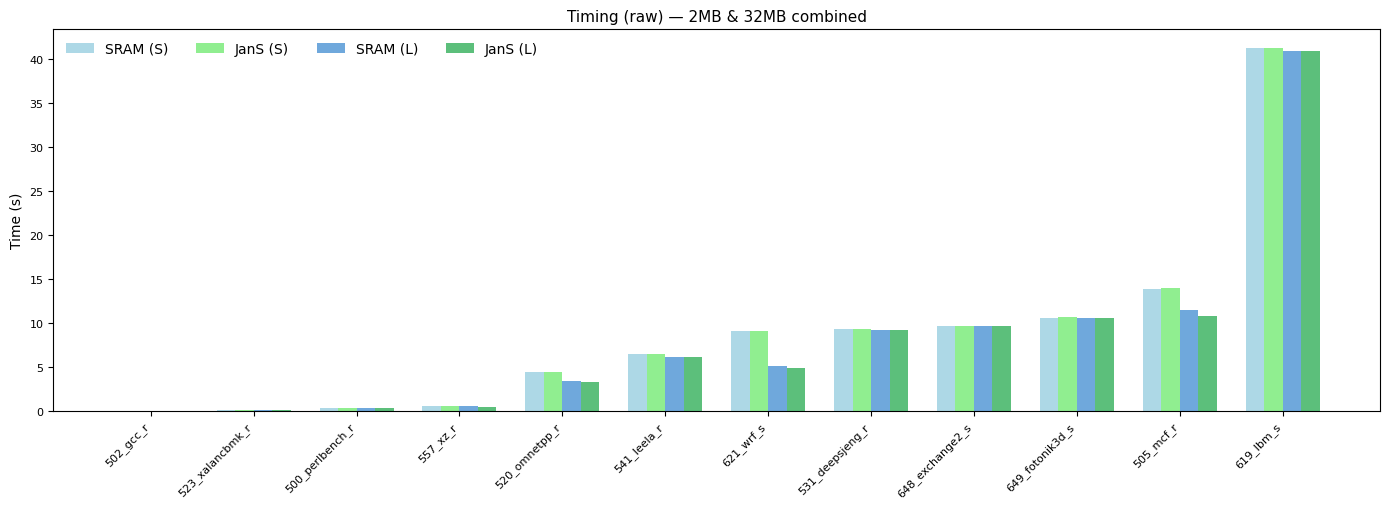

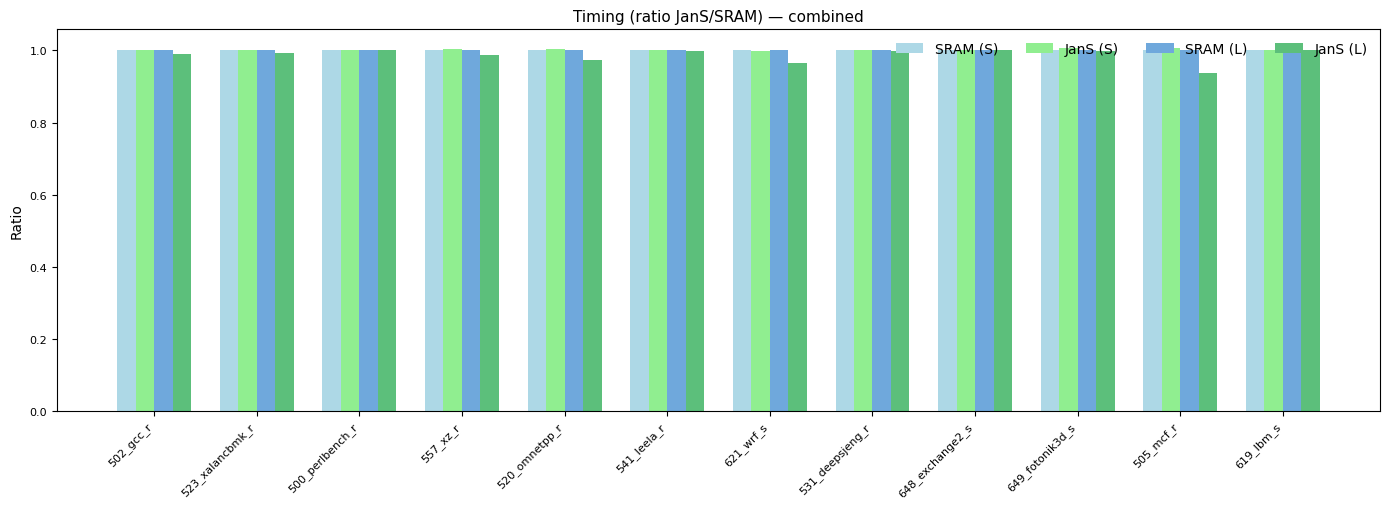

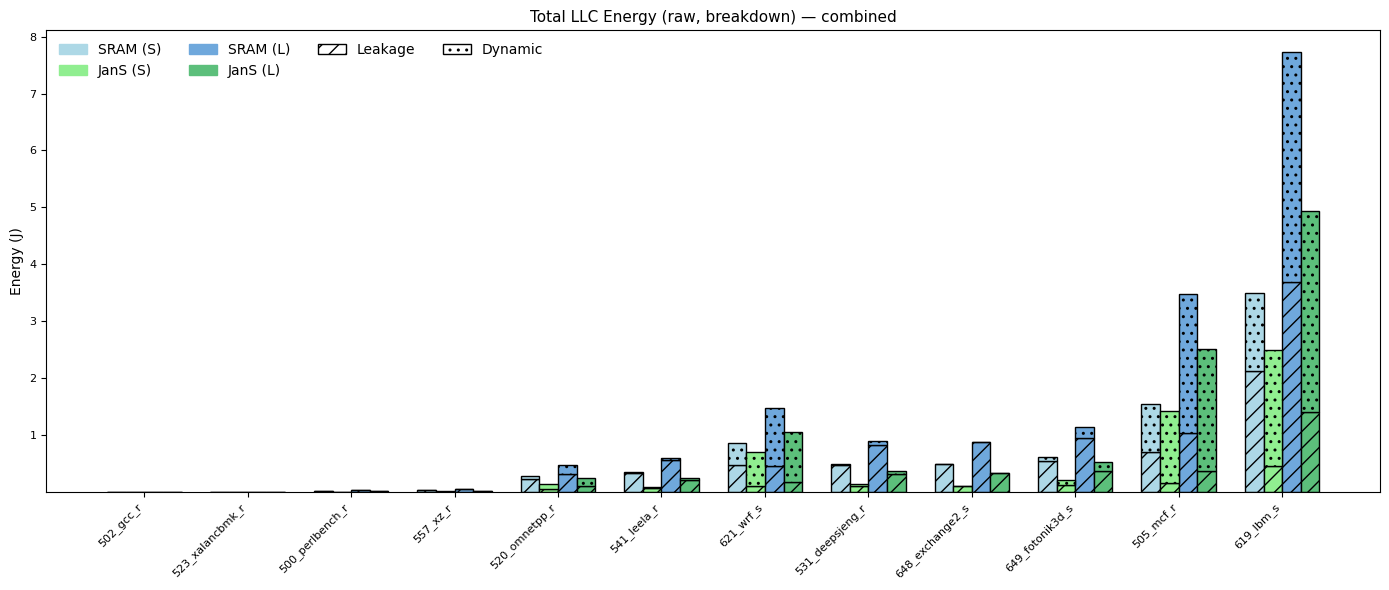

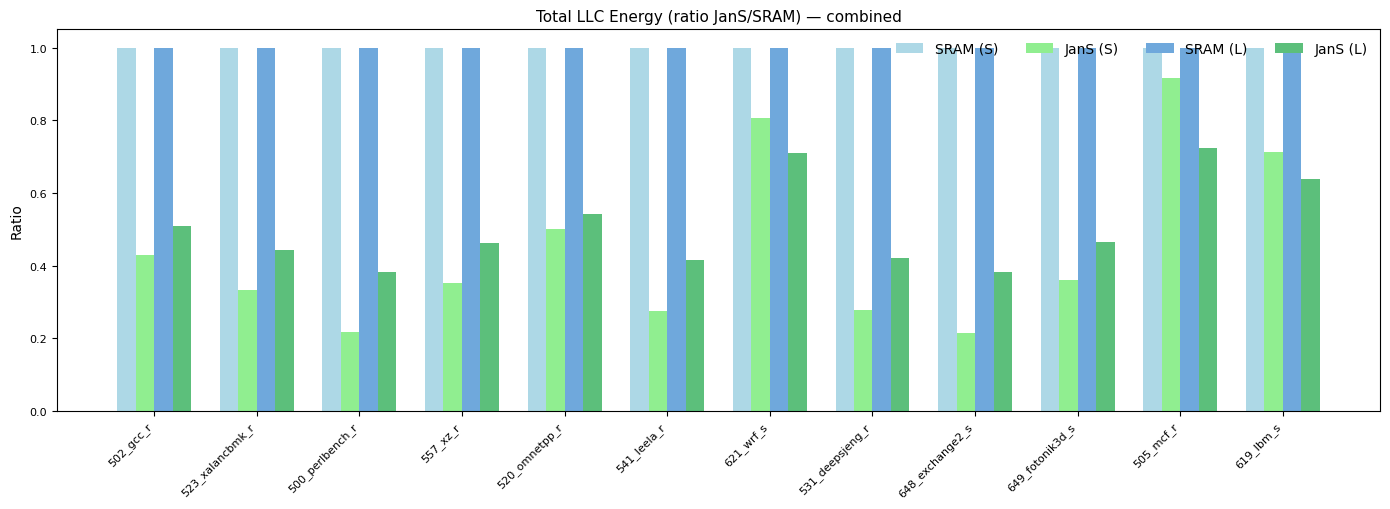

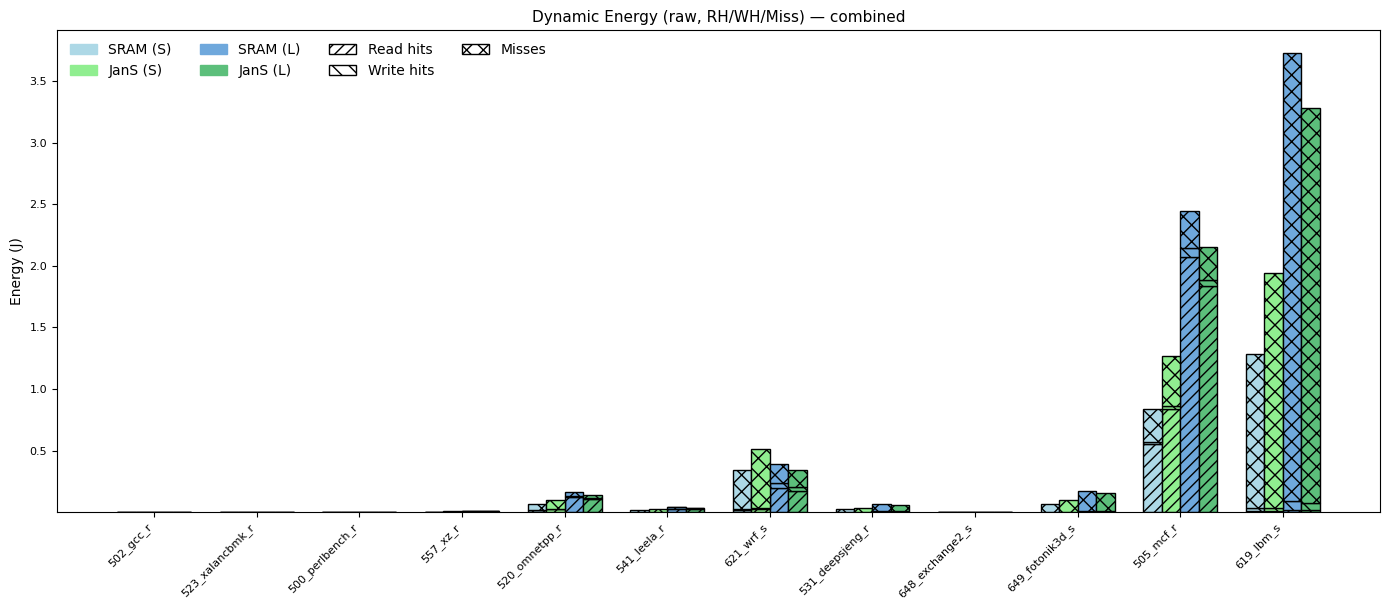

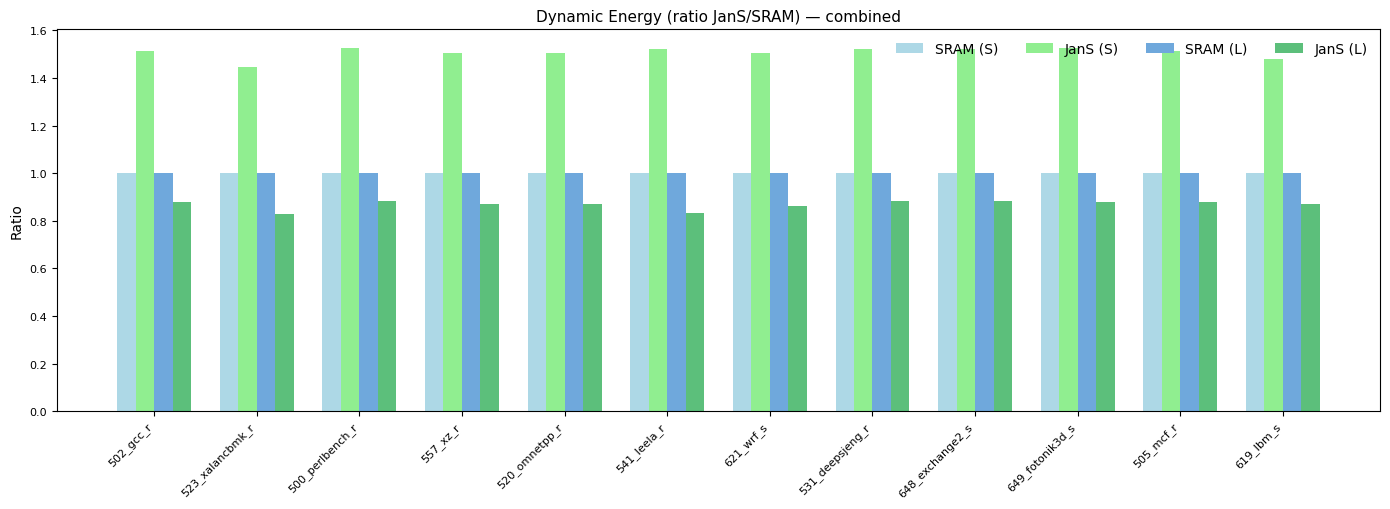

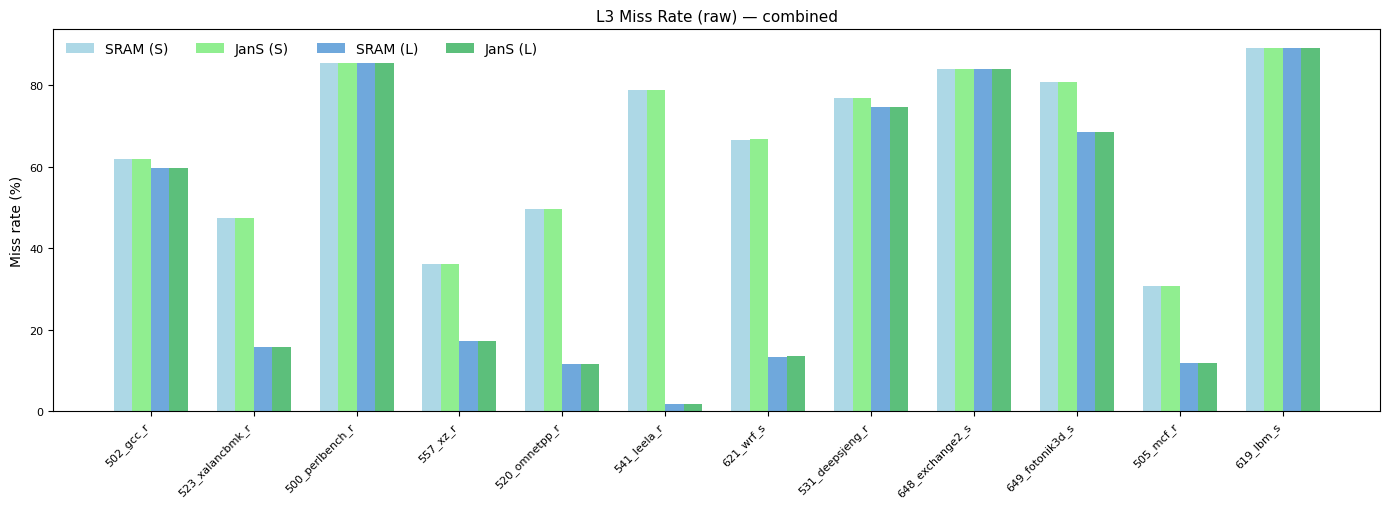

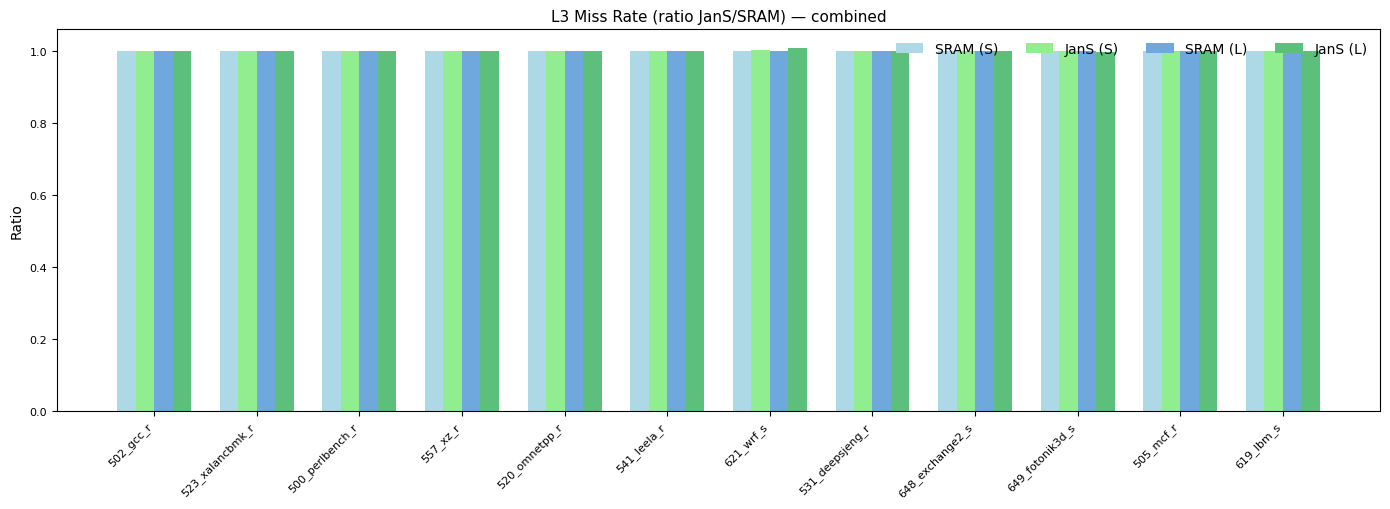

In [15]:
# ===========================
# COMBINED (2MB+32MB) GROUPED BAR CHARTS
# Per benchmark: four bars — SRAM(S), JanS(S), SRAM(L), JanS(L)
# Metrics: Timing, Total LLC Energy (Leak+Dyn stacked), Dynamic Energy (RH/WH/Miss stacked), Miss Rate
# Versions: RAW and RATIO (JanS/SRAM)
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- EXACT result directories you pointed at
DIR_2MB  = "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_2mb_16w_20251002T020032Z"
DIR_32MB = "/home/skataoka26/COSC_498/miniMXE/results/sniper_llc_32mb_16w_20251002T020050Z"

# --- Visual constants
CLR_SRAM_S = "#ADD8E6"  # light blue (SRAM, 2MB)
CLR_JANS_S = "#90EE90"  # light green (JanS, 2MB)
CLR_SRAM_L = "#6FA8DC"  # slightly darker blue (SRAM, 32MB)
CLR_JANS_L = "#5CBF7B"  # slightly darker green (JanS, 32MB)

HATCH_LEAK = "//"
HATCH_DYN  = ".."
HATCH_RH   = "///"
HATCH_WH   = "\\\\"
HATCH_MS   = "xx"

# --- Per-access energies (pJ) from your YAML/NVSim
E_PJ = {
    "2MB": {
        "SRAM": {"read": 562.0,  "write": 534.0,  "miss": 562.0},
        "JanS": {"read": 859.0,  "write": 489.0,  "miss": 859.0},
    },
    "32MB": {
        "SRAM": {"read": 1650.0, "write": 1486.0, "miss": 1650.0},
        "JanS": {"read": 1458.0, "write": 1107.0, "miss": 1458.0},
    },
}
pJ2J = 1e-12

def _pivot_by_config(df, cols):
    keep = ["benchmark","config"] + [c for c in cols if c in df.columns]
    pv = df[keep].pivot_table(index="benchmark", columns="config",
                              values=[c for c in cols if c in df.columns])
    pv.columns = [f"{a}_{b}" for a,b in pv.columns]
    return pv

def _load_results(sniper_dir):
    df = parse_sniper(sniper_dir)
    df = df[df["config"].isin(["SRAM","JanS"])].copy()
    base = _pivot_by_config(df, ["time_s","energy_exact_J","leak_J","dyn_exact_nJ"])
    # dyn nJ -> dyn J
    if "dyn_exact_nJ_SRAM" in base.columns: base["dyn_exact_J_SRAM"] = pd.to_numeric(base["dyn_exact_nJ_SRAM"], errors="coerce")*1e-9
    if "dyn_exact_nJ_JanS" in base.columns: base["dyn_exact_J_JanS"] = pd.to_numeric(base["dyn_exact_nJ_JanS"], errors="coerce")*1e-9
    # L3 counters (best-effort)
    l3_cols = [c for c in df.columns if c.lower().startswith("l3_")]
    prefer  = ["l3_read_hits","l3_write_hits","l3_misses_db","l3_accesses_db","l3_miss_rate_pct"]
    keep = [c for c in prefer if c in df.columns]
    for c in l3_cols:
        if c not in keep: keep.append(c)
    cnt = _pivot_by_config(df, keep) if keep else pd.DataFrame(index=base.index)
    out = base.join(cnt, how="left")
    # derive access/miss/rate if missing
    for dev in ["SRAM","JanS"]:
        rh, wh, ms, acc, rate = (f"l3_read_hits_{dev}", f"l3_write_hits_{dev}",
                                 f"l3_misses_db_{dev}", f"l3_accesses_db_{dev}", f"l3_miss_rate_pct_{dev}")
        if acc not in out and all(c in out for c in [rh,wh,ms]):
            out[acc] = pd.to_numeric(out[rh], errors="coerce") + pd.to_numeric(out[wh], errors="coerce") + pd.to_numeric(out[ms], errors="coerce")
        if ms not in out and all(c in out for c in [acc,rh,wh]):
            out[ms] = pd.to_numeric(out[acc], errors="coerce") - pd.to_numeric(out[rh], errors="coerce") - pd.to_numeric(out[wh], errors="coerce")
        if rate not in out and acc in out and ms in out:
            out[rate] = safe_div(pd.to_numeric(out[ms], errors="coerce"), pd.to_numeric(out[acc], errors="coerce")) * 100.0
    return out

def _align_benchmarks(df2, df32):
    common = df2.index.intersection(df32.index)
    df2 = df2.loc[common].copy()
    df32 = df32.loc[common].copy()
    # Order by SRAM(2MB) time ascending
    if "time_s_SRAM" in df2.columns:
        order = list(df2.sort_values("time_s_SRAM").index)
        return df2.loc[order], df32.loc[order], order
    order = list(common)
    return df2.loc[order], df32.loc[order], order

def _group4(ax, labels, s_sram, s_jans, l_sram, l_jans, title, ylabel):
    n = len(labels); x = np.arange(n); w = 0.18
    ax.bar(x - 3*w/2, s_sram, width=w, color=CLR_SRAM_S, label="SRAM (S)")
    ax.bar(x -   w/2, s_jans, width=w, color=CLR_JANS_S, label="JanS (S)")
    ax.bar(x +   w/2, l_sram, width=w, color=CLR_SRAM_L, label="SRAM (L)")
    ax.bar(x + 3*w/2, l_jans, width=w, color=CLR_JANS_L, label="JanS (L)")
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title(title); ax.set_ylabel(ylabel)
    ax.legend(ncol=4, frameon=False)

def _stacked4(ax, labels, s_sram_parts, s_jans_parts, l_sram_parts, l_jans_parts,
              comp_order, comp_hatch, title, ylabel):
    """Stacked four bars per benchmark with hatches for components."""
    n = len(labels); x = np.arange(n); w = 0.18
    bottoms = {k: np.zeros(n) for k in ["S_SRAM","S_JANS","L_SRAM","L_JANS"]}
    colors  = {"S_SRAM": CLR_SRAM_S, "S_JANS": CLR_JANS_S, "L_SRAM": CLR_SRAM_L, "L_JANS": CLR_JANS_L}
    xpos    = {"S_SRAM": x - 3*w/2,  "S_JANS": x - w/2,    "L_SRAM": x + w/2,    "L_JANS": x + 3*w/2}

    for comp in comp_order:
        ax.bar(xpos["S_SRAM"], s_sram_parts[comp], width=w, color=colors["S_SRAM"], hatch=comp_hatch[comp], edgecolor="k", bottom=bottoms["S_SRAM"])
        ax.bar(xpos["S_JANS"], s_jans_parts[comp], width=w, color=colors["S_JANS"], hatch=comp_hatch[comp], edgecolor="k", bottom=bottoms["S_JANS"])
        ax.bar(xpos["L_SRAM"], l_sram_parts[comp], width=w, color=colors["L_SRAM"], hatch=comp_hatch[comp], edgecolor="k", bottom=bottoms["L_SRAM"])
        ax.bar(xpos["L_JANS"], l_jans_parts[comp], width=w, color=colors["L_JANS"], hatch=comp_hatch[comp], edgecolor="k", bottom=bottoms["L_JANS"])
        bottoms["S_SRAM"] += np.array(s_sram_parts[comp], dtype=float)
        bottoms["S_JANS"] += np.array(s_jans_parts[comp], dtype=float)
        bottoms["L_SRAM"] += np.array(l_sram_parts[comp], dtype=float)
        bottoms["L_JANS"] += np.array(l_jans_parts[comp], dtype=float)

    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title(title); ax.set_ylabel(ylabel)
    # Legend: devices + components
    devs = [plt.Rectangle((0,0),1,1,color=CLR_SRAM_S,label="SRAM (S)"),
            plt.Rectangle((0,0),1,1,color=CLR_JANS_S,label="JanS (S)"),
            plt.Rectangle((0,0),1,1,color=CLR_SRAM_L,label="SRAM (L)"),
            plt.Rectangle((0,0),1,1,color=CLR_JANS_L,label="JanS (L)")]
    comps = [plt.Rectangle((0,0),1,1,facecolor="white",edgecolor="k",hatch=comp_hatch[c],label=c) for c in comp_order]
    ax.legend(devs+comps, [h.get_label() for h in devs+comps], ncol=4, frameon=False)

def _dyn_breakdown_J(df, cap_label):
    """Return component dicts (arrays) for each dev at this capacity: Read hits / Write hits / Misses (J)."""
    ep = E_PJ[cap_label]
    # may be NaN; OK – gaps will show
    rh_s = pd.to_numeric(df.get("l3_read_hits_SRAM", np.nan), errors="coerce")
    wh_s = pd.to_numeric(df.get("l3_write_hits_SRAM", np.nan), errors="coerce")
    ms_s = pd.to_numeric(df.get("l3_misses_db_SRAM", np.nan), errors="coerce")
    rh_j = pd.to_numeric(df.get("l3_read_hits_JanS", np.nan), errors="coerce")
    wh_j = pd.to_numeric(df.get("l3_write_hits_JanS", np.nan), errors="coerce")
    ms_j = pd.to_numeric(df.get("l3_misses_db_JanS", np.nan), errors="coerce")

    s_sram = {"Read hits": rh_s * ep["SRAM"]["read"]  * pJ2J,
              "Write hits": wh_s * ep["SRAM"]["write"] * pJ2J,
              "Misses":     ms_s * ep["SRAM"]["miss"]  * pJ2J}
    s_jans = {"Read hits": rh_j * ep["JanS"]["read"]  * pJ2J,
              "Write hits": wh_j * ep["JanS"]["write"] * pJ2J,
              "Misses":     ms_j * ep["JanS"]["miss"]  * pJ2J}
    return s_sram, s_jans

def _save(fig, name):
    fig.tight_layout()
    fig.savefig(name, dpi=200, bbox_inches="tight")
    print(f"[plots] Wrote {name}")

# ---- Load, align, and build figures
df2  = _load_results(DIR_2MB)
df32 = _load_results(DIR_32MB)
df2, df32, order = _align_benchmarks(df2, df32)

# ---- TIMING (RAW)
fig, ax = plt.subplots(figsize=(max(14, 0.95*len(order)), 5.2))
_group4(ax, order,
        df2["time_s_SRAM"], df2["time_s_JanS"],
        df32["time_s_SRAM"], df32["time_s_JanS"],
        "Timing (raw) — 2MB & 32MB combined", "Time (s)")
_save(fig, "bar_time_raw_combined.png")

# ---- TIMING (RATIO JanS/SRAM) — four bars; SRAM bars = 1.0
fig, ax = plt.subplots(figsize=(max(14, 0.95*len(order)), 5.2))
_group4(ax, order,
        np.ones(len(order)), safe_div(df2["time_s_JanS"], df2["time_s_SRAM"]),
        np.ones(len(order)), safe_div(df32["time_s_JanS"], df32["time_s_SRAM"]),
        "Timing (ratio JanS/SRAM) — combined", "Ratio")
_save(fig, "bar_time_ratio_combined.png")

# ---- TOTAL LLC ENERGY (RAW, stacked Leak + Dyn) — four bars
leak_s_s = pd.to_numeric(df2["leak_J_SRAM"], errors="coerce").values
leak_s_j = pd.to_numeric(df2["leak_J_JanS"], errors="coerce").values
leak_l_s = pd.to_numeric(df32["leak_J_SRAM"], errors="coerce").values
leak_l_j = pd.to_numeric(df32["leak_J_JanS"], errors="coerce").values

dyn_s_s = pd.to_numeric(df2.get("dyn_exact_J_SRAM", df2["energy_exact_J_SRAM"]-df2["leak_J_SRAM"]), errors="coerce").values
dyn_s_j = pd.to_numeric(df2.get("dyn_exact_J_JanS", df2["energy_exact_J_JanS"]-df2["leak_J_JanS"]), errors="coerce").values
dyn_l_s = pd.to_numeric(df32.get("dyn_exact_J_SRAM", df32["energy_exact_J_SRAM"]-df32["leak_J_SRAM"]), errors="coerce").values
dyn_l_j = pd.to_numeric(df32.get("dyn_exact_J_JanS", df32["energy_exact_J_JanS"]-df32["leak_J_JanS"]), errors="coerce").values

parts_s_s = {"Leakage": leak_s_s, "Dynamic": dyn_s_s}
parts_s_j = {"Leakage": leak_s_j, "Dynamic": dyn_s_j}
parts_l_s = {"Leakage": leak_l_s, "Dynamic": dyn_l_s}
parts_l_j = {"Leakage": leak_l_j, "Dynamic": dyn_l_j}

fig, ax = plt.subplots(figsize=(max(14, 1.05*len(order)), 6.0))
_stacked4(ax, order, parts_s_s, parts_s_j, parts_l_s, parts_l_j,
          ["Leakage","Dynamic"], {"Leakage": HATCH_LEAK, "Dynamic": HATCH_DYN},
          "Total LLC Energy (raw, breakdown) — combined", "Energy (J)")
_save(fig, "bar_energy_total_raw_combined.png")

# ---- TOTAL LLC ENERGY (RATIO JanS/SRAM) — four bars; SRAM bars = 1.0
Etot_s_s = pd.to_numeric(df2["energy_exact_J_SRAM"], errors="coerce").values
Etot_s_j = pd.to_numeric(df2["energy_exact_J_JanS"], errors="coerce").values
Etot_l_s = pd.to_numeric(df32["energy_exact_J_SRAM"], errors="coerce").values
Etot_l_j = pd.to_numeric(df32["energy_exact_J_JanS"], errors="coerce").values

fig, ax = plt.subplots(figsize=(max(14, 0.95*len(order)), 5.2))
_group4(ax, order,
        np.ones(len(order)), safe_div(Etot_s_j, Etot_s_s),
        np.ones(len(order)), safe_div(Etot_l_j, Etot_l_s),
        "Total LLC Energy (ratio JanS/SRAM) — combined", "Ratio")
_save(fig, "bar_energy_total_ratio_combined.png")

# ---- DYNAMIC ENERGY (RAW, breakdown RH/WH/Miss) — four bars
s_sram_comp2, s_jans_comp2 = _dyn_breakdown_J(df2,  "2MB")
l_sram_comp2, l_jans_comp2 = _dyn_breakdown_J(df32, "32MB")

fig, ax = plt.subplots(figsize=(max(14, 1.05*len(order)), 6.2))
_stacked4(ax, order, s_sram_comp2, s_jans_comp2, l_sram_comp2, l_jans_comp2,
          ["Read hits","Write hits","Misses"],
          {"Read hits": HATCH_RH, "Write hits": HATCH_WH, "Misses": HATCH_MS},
          "Dynamic Energy (raw, RH/WH/Miss) — combined", "Energy (J)")
_save(fig, "bar_energy_dyn_raw_combined.png")

# ---- DYNAMIC ENERGY (RATIO JanS/SRAM) — four bars; SRAM bars = 1.0
Dyn_s_s = dyn_s_s
Dyn_s_j = dyn_s_j
Dyn_l_s = dyn_l_s
Dyn_l_j = dyn_l_j

fig, ax = plt.subplots(figsize=(max(14, 0.95*len(order)), 5.2))
_group4(ax, order,
        np.ones(len(order)), safe_div(Dyn_s_j, Dyn_s_s),
        np.ones(len(order)), safe_div(Dyn_l_j, Dyn_l_s),
        "Dynamic Energy (ratio JanS/SRAM) — combined", "Ratio")
_save(fig, "bar_energy_dyn_ratio_combined.png")

# ---- MISS RATE (RAW)
mr_s_s = pd.to_numeric(df2.get("l3_miss_rate_pct_SRAM", np.nan), errors="coerce").values
mr_s_j = pd.to_numeric(df2.get("l3_miss_rate_pct_JanS", np.nan), errors="coerce").values
mr_l_s = pd.to_numeric(df32.get("l3_miss_rate_pct_SRAM", np.nan), errors="coerce").values
mr_l_j = pd.to_numeric(df32.get("l3_miss_rate_pct_JanS", np.nan), errors="coerce").values

# if missing, derive from misses/accesses
if np.isnan(mr_s_s).all() or np.isnan(mr_s_j).all() or np.isnan(mr_l_s).all() or np.isnan(mr_l_j).all():
    for dev, cap, dfX, out_arr in [("SRAM","2MB", df2, "mr_s_s"), ("JanS","2MB", df2, "mr_s_j"),
                                   ("SRAM","32MB", df32, "mr_l_s"), ("JanS","32MB", df32, "mr_l_j")]:
        ms = pd.to_numeric(dfX.get(f"l3_misses_db_{dev}", np.nan), errors="coerce").values
        ac = pd.to_numeric(dfX.get(f"l3_accesses_db_{dev}", np.nan), errors="coerce").values
        locals()[out_arr] = safe_div(ms, ac) * 100.0

fig, ax = plt.subplots(figsize=(max(14, 0.95*len(order)), 5.2))
_group4(ax, order, mr_s_s, mr_s_j, mr_l_s, mr_l_j,
        "L3 Miss Rate (raw) — combined", "Miss rate (%)")
_save(fig, "bar_missrate_raw_combined.png")

# ---- MISS RATE (RATIO JanS/SRAM) — four bars; SRAM bars = 1.0
fig, ax = plt.subplots(figsize=(max(14, 0.95*len(order)), 5.2))
_group4(ax, order,
        np.ones(len(order)), safe_div(mr_s_j, mr_s_s),
        np.ones(len(order)), safe_div(mr_l_j, mr_l_s),
        "L3 Miss Rate (ratio JanS/SRAM) — combined", "Ratio")
_save(fig, "bar_missrate_ratio_combined.png")

print("[plots] Done.")
